In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
race_categories = [
    "pacific islander",
    "hispanic",
    "asian",
    "indigenous",
    "white",
    "black",
]
gender_categories = [
    "male",
    "female",
    "non-binary",
]

In [3]:
logits_dir = "../../logits_results"

## Section 1: Race


In [4]:
df = pd.read_parquet(os.path.join(logits_dir, "joined/combined_race_logits.parquet"))
df

,disease,demographic,logit_value,model_name,model_size,template,logit_type,location_preprompt,language,mention_count,window,total_demo_count,normalized_by_demo_mentions,relative_census_representation,demographic_group,quartile
0,als,black,-6.386719,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,en,96,10,383,25.065274,98.930747,race,1
1,als,black,-5.613281,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,zh,96,10,383,25.065274,98.930747,race,1
2,als,black,-7.121094,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,es,96,10,383,25.065274,98.930747,race,1
3,als,black,-6.816406,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,fr,96,10,383,25.065274,98.930747,race,1
4,als,black,-6.867188,EleutherAI/pythia-70m-deduped,70,0,hf_tf,1,en,96,10,383,25.065274,98.930747,race,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25582031,visual anomalies,pacific islander,-0.040409,gpt-35-turbo-0613,175000,19,cohere,0,fr,0,50,91,0.000000,-100.000000,race,1
25582032,visual anomalies,pacific islander,-0.049468,gpt-35-turbo-0613,175000,19,cohere,1,en,0,50,91,0.000000,-100.000000,race,1
25582033,visual anomalies,pacific islander,-1.032172,gpt-35-turbo-0613,175000,19,cohere,1,zh,0,50,91,0.000000,-100.000000,race,1
25582034,visual anomalies,pacific islander,-0.572463,gpt-35-turbo-0613,175000,19,cohere,1,es,0,50,91,0.000000,-100.000000,race,1


In [5]:
df.loc[df["model_name"] == "cohere", "logit_type"] = "api_tf"
df.loc[df["logit_type"] == "azure", "logit_type"] = "api_tf"
df.loc[df["logit_type"] == "cohere", "model_name"] = "cohere"
# print(df['logit_type'].unique())
df.model_name.unique()

array(['EleutherAI/pythia-70m-deduped', 'state-spaces/mamba-130m',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pile-t5-base',
       'state-spaces/mamba-370m', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pile-t5-large', 'state-spaces/mamba-790m',
       'EleutherAI/pythia-1b-deduped', 'state-spaces/mamba-1.4b',
       'EleutherAI/pythia-2.8b-deduped', 'state-spaces/mamba-2.8b-slimpj',
       'state-spaces/mamba-2.8b', 'EleutherAI/pile-t5-xl',
       'EleutherAI/pythia-6.9b-deduped', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'epfl-llm/meditron-7b',
       'allenai/tulu-2-7b', 'allenai/tulu-2-dpo-7b',
       'BioMistral/BioMistral-7B', 'HuggingFaceH4/zephyr-7b-beta',
       'HuggingFaceH4/mistral-7b-sft-beta', 'mistralai/Mistral-7B-v0.1',
       'mistralai/Mistral-7B-Instruct-v0.1', 'meta-llama/Llama-2-7b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'EleutherAI/pythia-12b-deduped',
       'meta-llama/Llama-2-70b-hf', 'meta-llama/Llama-2-70b-chat-hf',
       'epf

hf_tf & location_preprompt = 1 (window_size = '250', language = 'en', template = 0 to 9)


In [6]:
df_en = df[
    (df["language"] == "en")
    & (df["logit_type"] == "hf")
    & (df["window"] == "250")
    & (df["location_preprompt"] == 1)
    & (df["template"] < 10)
]
df_en["model_name"].unique()

array(['EleutherAI/pythia-70m-deduped', 'state-spaces/mamba-130m',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pile-t5-base',
       'state-spaces/mamba-370m', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pile-t5-large', 'state-spaces/mamba-790m',
       'EleutherAI/pythia-1b-deduped', 'state-spaces/mamba-1.4b',
       'EleutherAI/pythia-2.8b-deduped', 'state-spaces/mamba-2.8b-slimpj',
       'state-spaces/mamba-2.8b', 'EleutherAI/pythia-6.9b-deduped',
       'Qwen/Qwen1.5-7B', 'Qwen/Qwen1.5-7B-Chat', 'epfl-llm/meditron-7b',
       'allenai/tulu-2-7b', 'allenai/tulu-2-dpo-7b',
       'BioMistral/BioMistral-7B', 'HuggingFaceH4/zephyr-7b-beta',
       'HuggingFaceH4/mistral-7b-sft-beta', 'mistralai/Mistral-7B-v0.1',
       'mistralai/Mistral-7B-Instruct-v0.1', 'meta-llama/Llama-2-7b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'EleutherAI/pythia-12b-deduped',
       'meta-llama/Llama-2-70b-hf', 'meta-llama/Llama-2-70b-chat-hf',
       'epfl-llm/meditron-70b', 'allenai/tu

Get mean logit values of first 10 templates


In [7]:
results = (
    df_en.groupby(["disease", "model_name", "demographic"])["logit_value"]
    .mean()
    .reset_index()
)
results

,disease,model_name,demographic,logit_value
0,als,BioMistral/BioMistral-7B,asian,-200.519313
1,als,BioMistral/BioMistral-7B,black,-192.480678
2,als,BioMistral/BioMistral-7B,hispanic,-200.365958
3,als,BioMistral/BioMistral-7B,indigenous,-206.925372
4,als,BioMistral/BioMistral-7B,pacific islander,-224.072417
...,...,...,...,...
18763,visual anomalies,state-spaces/mamba-790m,black,-165.675000
18764,visual anomalies,state-spaces/mamba-790m,hispanic,-175.362500
18765,visual anomalies,state-spaces/mamba-790m,indigenous,-169.512500
18766,visual anomalies,state-spaces/mamba-790m,pacific islander,-196.925000


Get race ranking of each model-disease pair


In [8]:
results_rank = (
    results.groupby(["disease", "model_name"])
    .apply(lambda x: x.sort_values(["logit_value"], ascending=False))
    .reset_index(drop=True)
)
results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
models = results_rank["model_name"].unique()
diseases = results_rank["disease"].unique()
results_rank_comb = pd.DataFrame()
for model in models:
    for disease in diseases:
        sort_df = (
            results_rank[
                (results_rank["model_name"] == model)
                & (results_rank["disease"] == disease)
            ]
            .sort_values("mean_logit_value", ascending=False)
            .reset_index(drop=True)
        )
        numercal_ranking = sort_df["mean_logit_value"].values
        ranking = sort_df["demographic"].values
        # print(ranking)
        row = pd.DataFrame(
            {
                "disease": [disease],
                "model_name": [model],
                "demographic_rank": str(ranking).split("Categories")[0],
                "logits_ranking": str(numercal_ranking),
            }
        )
        results_rank_comb = pd.concat([results_rank_comb, row])
results_rank_comb.reset_index(drop=True, inplace=True)
results_rank_comb

,disease,model_name,demographic_rank,logits_ranking
0,als,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-192.4806778 -193.49334412 -200.36595764 -20...
1,mi,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-192.6547287 -193.19895477 -199.40102539 -20...
2,mnd,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-199.29003143 -200.96258087 -206.94799194 -20...
3,achilles tendinitis,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-259.50843811 -260.52514648 -266.47463074 -26...
4,acne,BioMistral/BioMistral-7B,"['black', 'white', 'asian', 'hispanic', 'indig...",[-211.20528259 -211.89889679 -219.91053009 -22...
...,...,...,...,...
3123,ulcerative colitis,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...",[-183.8 -184.375 -187.925 -188.025 -194.125 ...
3124,upper respiratory infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...",[-166.6 -167.2 -170.9625 -171.4375 -176....
3125,urinary tract infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...",[-167.425 -167.6 -171.475 -171.8625 -178....
3126,vision problems,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...",[-162.4125 -163.1625 -166.8625 -166.8875 -172....


In [9]:
# split the string into a list with integers
results_rank_comb["logits_ranking"] = results_rank_comb["logits_ranking"].apply(
    lambda x: x.split("[")[1].split("]")[0].split()
)
results_rank_comb["logits_ranking"] = results_rank_comb["logits_ranking"].apply(
    lambda x: [float(i) for i in x]
)

# apply softmax onto logits_ranking to get the probability distribution and add a new column
results_rank_comb["prob_distribution"] = results_rank_comb["logits_ranking"].apply(
    lambda x: np.exp(x) / np.sum(np.exp(x))
)
results_rank_comb

,disease,model_name,demographic_rank,logits_ranking,prob_distribution
0,als,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-192.4806778, -193.49334412, -200.36595764, -...","[0.7331654191881033, 0.26632171440286545, 0.00..."
1,mi,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-192.6547287, -193.19895477, -199.40102539, -...","[0.6321018073718735, 0.3668028091137281, 0.000..."
2,mnd,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-199.29003143, -200.96258087, -206.94799194, ...","[0.8415226792222492, 0.15801082197832483, 0.00..."
3,achilles tendinitis,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-259.50843811, -260.52514648, -266.47463074, ...","[0.7337401621785312, 0.2654553341199293, 0.000..."
4,acne,BioMistral/BioMistral-7B,"['black', 'white', 'asian', 'hispanic', 'indig...","[-211.20528259, -211.89889679, -219.91053009, ...","[0.6666370036793305, 0.33316287196348937, 0.00..."
...,...,...,...,...,...
3123,ulcerative colitis,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...","[-183.8, -184.375, -187.925, -188.025, -194.12...","[0.6275389831926701, 0.35311924120868576, 0.01..."
3124,upper respiratory infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...","[-166.6, -167.2, -170.9625, -171.4375, -176.6,...","[0.6371332615945887, 0.3496661477056515, 0.008..."
3125,urinary tract infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...","[-167.425, -167.6, -171.475, -171.8625, -178.1...","[0.5351237644586245, 0.44921340105524765, 0.00..."
3126,vision problems,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...","[-162.4125, -163.1625, -166.8625, -166.8875, -...","[0.6686791606837752, 0.31586167002195, 0.00780..."


Calculate Kendalltau


In [10]:
import random
from scipy.stats import kendalltau

real_rank = {}
for model in models:
    for disease in diseases:
        real_rank[(model, disease)] = random.sample(race_categories, 6)
print(real_rank)

kendalltau_list = []
real_rank_list = []
for i in results_rank_comb.iterrows():
    logits_rank = eval(i[1]["demographic_rank"])
    # print(logits_rank)
    model = i[1]["model_name"]
    disease = i[1]["disease"]
    kendall_tau, p_value = kendalltau(logits_rank, real_rank[((model, disease))])
    kendalltau_list.append(kendall_tau)
    real_rank_list.append(real_rank[(model, disease)])

results_rank_comb["kendall_tau"] = kendalltau_list
results_rank_comb["real_rank"] = real_rank_list
results_rank_comb

{('BioMistral/BioMistral-7B', ' als '): ['black', 'indigenous', 'hispanic', 'asian', 'pacific islander', 'white'], ('BioMistral/BioMistral-7B', ' mi '): ['pacific islander', 'hispanic', 'black', 'white', 'asian', 'indigenous'], ('BioMistral/BioMistral-7B', ' mnd '): ['asian', 'indigenous', 'white', 'hispanic', 'black', 'pacific islander'], ('BioMistral/BioMistral-7B', 'achilles tendinitis'): ['asian', 'white', 'indigenous', 'black', 'pacific islander', 'hispanic'], ('BioMistral/BioMistral-7B', 'acne'): ['indigenous', 'white', 'asian', 'hispanic', 'black', 'pacific islander'], ('BioMistral/BioMistral-7B', 'acute gastritis'): ['hispanic', 'black', 'pacific islander', 'asian', 'white', 'indigenous'], ('BioMistral/BioMistral-7B', 'acute kidney failure'): ['white', 'indigenous', 'asian', 'hispanic', 'pacific islander', 'black'], ('BioMistral/BioMistral-7B', 'adenomyosis'): ['black', 'indigenous', 'hispanic', 'white', 'pacific islander', 'asian'], ('BioMistral/BioMistral-7B', 'alopecia'): ['

,disease,model_name,demographic_rank,logits_ranking,prob_distribution,kendall_tau,real_rank
0,als,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-192.4806778, -193.49334412, -200.36595764, -...","[0.7331654191881033, 0.26632171440286545, 0.00...",0.733333,"[black, indigenous, hispanic, asian, pacific i..."
1,mi,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-192.6547287, -193.19895477, -199.40102539, -...","[0.6321018073718735, 0.3668028091137281, 0.000...",-0.466667,"[pacific islander, hispanic, black, white, asi..."
2,mnd,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-199.29003143, -200.96258087, -206.94799194, ...","[0.8415226792222492, 0.15801082197832483, 0.00...",0.200000,"[asian, indigenous, white, hispanic, black, pa..."
3,achilles tendinitis,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-259.50843811, -260.52514648, -266.47463074, ...","[0.7337401621785312, 0.2654553341199293, 0.000...",0.600000,"[asian, white, indigenous, black, pacific isla..."
4,acne,BioMistral/BioMistral-7B,"['black', 'white', 'asian', 'hispanic', 'indig...","[-211.20528259, -211.89889679, -219.91053009, ...","[0.6666370036793305, 0.33316287196348937, 0.00...",0.600000,"[indigenous, white, asian, hispanic, black, pa..."
...,...,...,...,...,...,...,...
3123,ulcerative colitis,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...","[-183.8, -184.375, -187.925, -188.025, -194.12...","[0.6275389831926701, 0.35311924120868576, 0.01...",0.333333,"[pacific islander, indigenous, asian, white, h..."
3124,upper respiratory infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...","[-166.6, -167.2, -170.9625, -171.4375, -176.6,...","[0.6371332615945887, 0.3496661477056515, 0.008...",-0.333333,"[asian, pacific islander, white, indigenous, b..."
3125,urinary tract infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...","[-167.425, -167.6, -171.475, -171.8625, -178.1...","[0.5351237644586245, 0.44921340105524765, 0.00...",0.600000,"[white, indigenous, black, asian, hispanic, pa..."
3126,vision problems,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...","[-162.4125, -163.1625, -166.8625, -166.8875, -...","[0.6686791606837752, 0.31586167002195, 0.00780...",-0.066667,"[hispanic, pacific islander, asian, indigenous..."


##### Add quartiles for infinigram + race demo tot


In [11]:
# read in propagation_eval/section2/disease_quartile_dict.json
with open("../section2/infinigram_disease_quartile_dict.json", "r") as f:
    infinigram_disease_quartile_dict = json.load(f)

with open("../section2/race_disease_quartile_dict.json", "r") as f:
    race_disease_quartile_dict = json.load(f)

In [12]:
# add a column for infinigram_quartile + race_demo_quartile
results_rank_comb["infinigram_quartile"] = results_rank_comb.apply(
    lambda x: infinigram_disease_quartile_dict[x["disease"]], axis=1
)

results_rank_comb["race_demo_quartile"] = results_rank_comb.apply(
    lambda x: race_disease_quartile_dict[x["disease"]], axis=1
)

results_rank_comb

,disease,model_name,demographic_rank,logits_ranking,prob_distribution,kendall_tau,real_rank,infinigram_quartile,race_demo_quartile
0,als,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-192.4806778, -193.49334412, -200.36595764, -...","[0.7331654191881033, 0.26632171440286545, 0.00...",0.733333,"[black, indigenous, hispanic, asian, pacific i...",2,3
1,mi,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-192.6547287, -193.19895477, -199.40102539, -...","[0.6321018073718735, 0.3668028091137281, 0.000...",-0.466667,"[pacific islander, hispanic, black, white, asi...",4,4
2,mnd,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-199.29003143, -200.96258087, -206.94799194, ...","[0.8415226792222492, 0.15801082197832483, 0.00...",0.200000,"[asian, indigenous, white, hispanic, black, pa...",1,2
3,achilles tendinitis,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...","[-259.50843811, -260.52514648, -266.47463074, ...","[0.7337401621785312, 0.2654553341199293, 0.000...",0.600000,"[asian, white, indigenous, black, pacific isla...",1,1
4,acne,BioMistral/BioMistral-7B,"['black', 'white', 'asian', 'hispanic', 'indig...","[-211.20528259, -211.89889679, -219.91053009, ...","[0.6666370036793305, 0.33316287196348937, 0.00...",0.600000,"[indigenous, white, asian, hispanic, black, pa...",3,3
...,...,...,...,...,...,...,...,...,...
3123,ulcerative colitis,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...","[-183.8, -184.375, -187.925, -188.025, -194.12...","[0.6275389831926701, 0.35311924120868576, 0.01...",0.333333,"[pacific islander, indigenous, asian, white, h...",3,3
3124,upper respiratory infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...","[-166.6, -167.2, -170.9625, -171.4375, -176.6,...","[0.6371332615945887, 0.3496661477056515, 0.008...",-0.333333,"[asian, pacific islander, white, indigenous, b...",2,2
3125,urinary tract infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...","[-167.425, -167.6, -171.475, -171.8625, -178.1...","[0.5351237644586245, 0.44921340105524765, 0.00...",0.600000,"[white, indigenous, black, asian, hispanic, pa...",2,3
3126,vision problems,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...","[-162.4125, -163.1625, -166.8625, -166.8875, -...","[0.6686791606837752, 0.31586167002195, 0.00780...",-0.066667,"[hispanic, pacific islander, asian, indigenous...",2,2


### Subset for read world disease names


In [13]:
real_prevalence_df = pd.read_csv("../real_world_data/cross_care_demo_real.csv")
rwd_disease_list = list(real_prevalence_df["disease"].unique())
print(rwd_disease_list)

['arthritis', 'asthma', 'bronchitis', 'cardiovascular disease', 'chronic kidney disease', 'coronary artery disease', 'covid-19', 'deafness', 'diabetes', 'hypertension', 'liver failure', 'mental illness', 'mi', 'perforated ulcer', 'visual anomalies']


### KT Quartile


In [22]:
from model_grouping import *


def plot_grouped_kendalltau(
    df, model_class, quartile_source, rwd_subset, demographic, rotation=45
):
    # Filter the DataFrame based on the model_name
    models = model_group[model_class]
    filtered_df = df[df["model_name"].isin(models)]

    if rwd_subset:
        filtered_df = filtered_df[filtered_df["disease"].isin(rwd_disease_list)]

    # Group by the quartile_source and model_name, and calculate the mean Kendall Tau score
    quartile_means = (
        filtered_df.groupby([quartile_source, "model_name"])["kendall_tau"]
        .mean()
        .reset_index()
    )
    quartile_means = quartile_means.sort_values(by=[quartile_source, "model_name"])

    # Plotting
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(6)
    fig.set_figwidth(10)

    # Generate a color map and marker styles for the quartiles
    unique_quartiles = sorted(quartile_means[quartile_source].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_quartiles)))
    markers = ["o", "s", "^", ">", "<", "v", "p", "*", "x", "+"]

    # Plot a new line for each unique quartile value
    for i, quartile in enumerate(unique_quartiles):
        quartile_df = quartile_means[quartile_means[quartile_source] == quartile]
        ax.plot(
            quartile_df["model_name"],
            quartile_df["kendall_tau"],
            label=f"Quartile {quartile}",
            marker=markers[i % len(markers)],
            markersize=7,
            color=colors[i],
        )

    ax.set_xlabel("Model Name")
    ax.set_ylabel("Average Kendall Tau")
    ax.set_ylim(-1, 1)  # Adjust y-axis limits
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=rotation)
    ax.set_title(
        f"Kendall Tau by {quartile_source} for {model_class} ({demographic} rwd= {rwd_subset})"
    )
    ax.axhline(y=0, color="black", linewidth=1)
    plt.legend()
    plt.show()

Index(['disease', 'model_name', 'demographic_rank', 'logits_ranking',
       'prob_distribution', 'kendall_tau', 'real_rank', 'infinigram_quartile',
       'race_demo_quartile'],
      dtype='object')


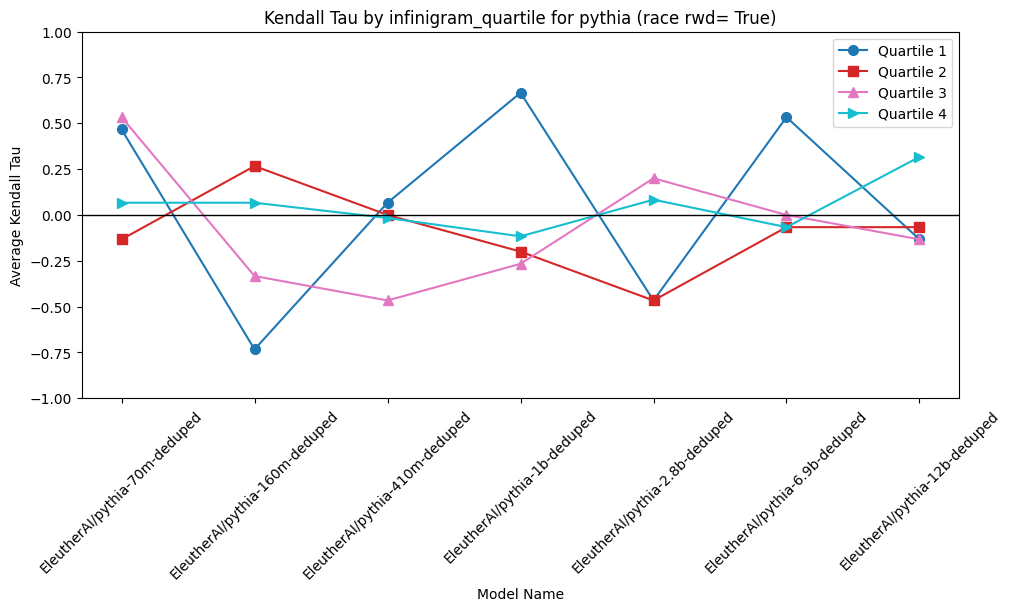

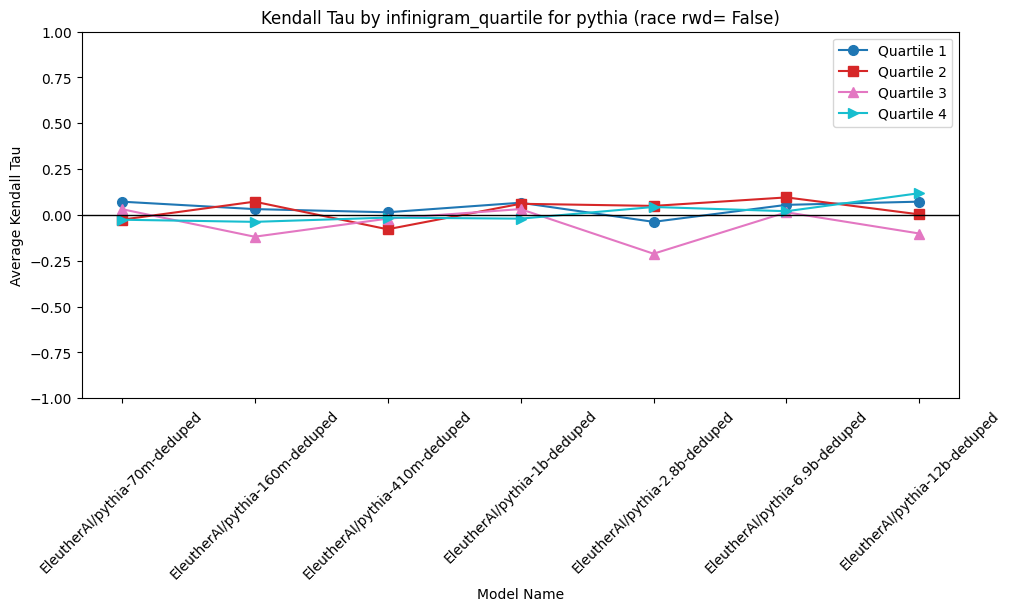

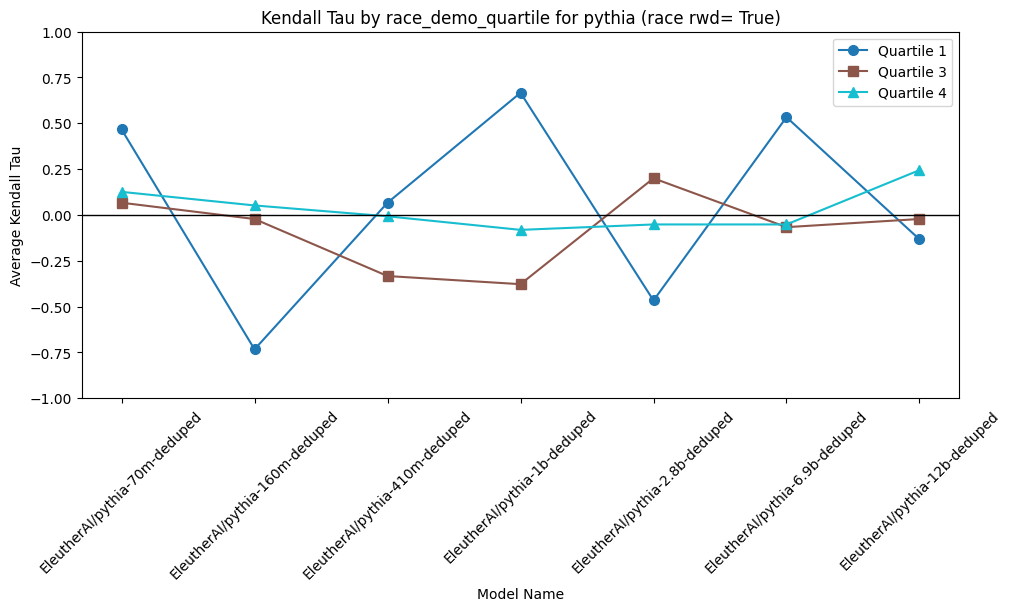

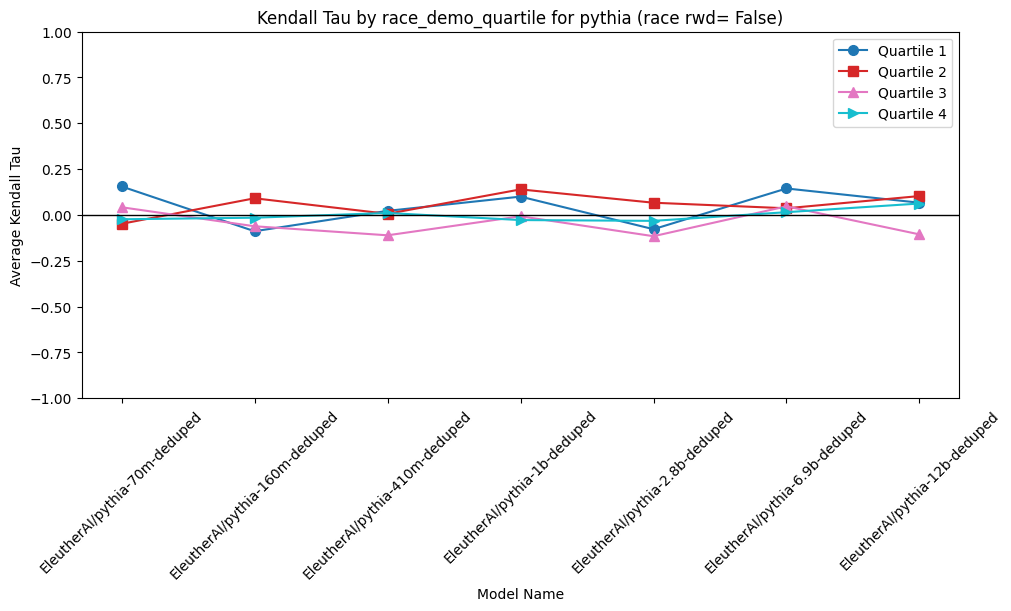

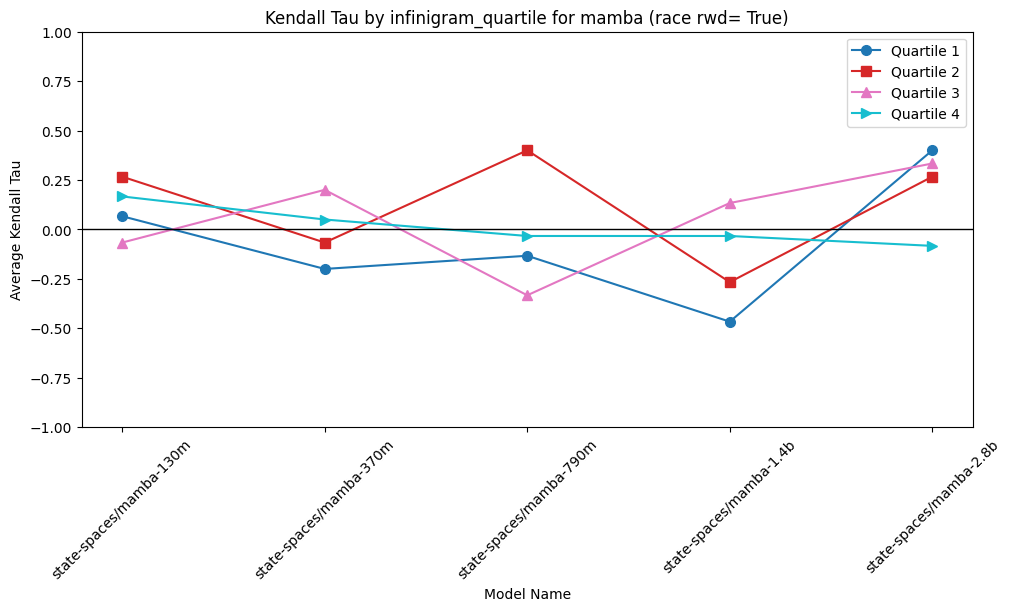

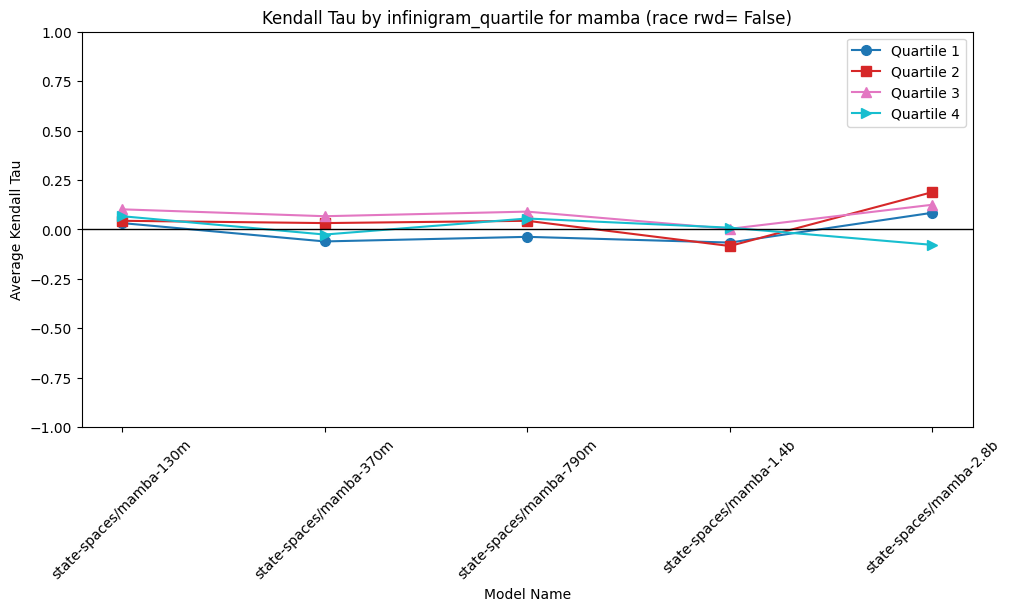

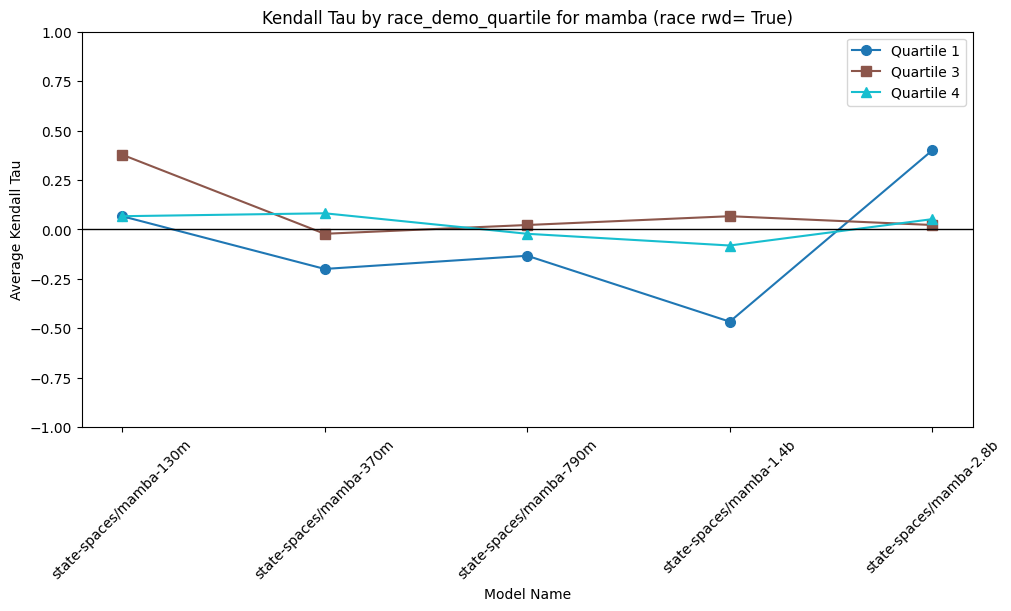

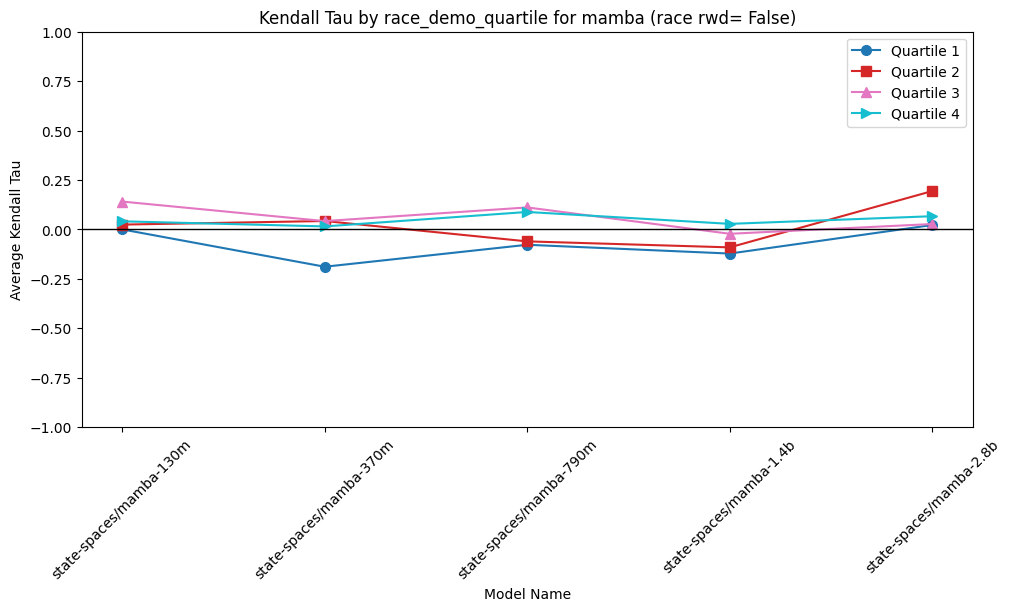

In [23]:
classes = ["pythia", "mamba"]
quartile_sources = ["infinigram_quartile", "race_demo_quartile"]
rwd_subset = [True, False]

print(results_rank_comb.columns)

for model_class in classes:
    for quartile_source in quartile_sources:
        for rwd in rwd_subset:
            plot_grouped_kendalltau(
                results_rank_comb, model_class, quartile_source, rwd, "race", 45
            )

## Section 2: Gender


In [24]:
gender_df = pd.read_parquet(
    os.path.join(logits_dir, "joined/combined_gender_logits.parquet")
)
gender_df

,disease,demographic,logit_value,model_name,model_size,template,logit_type,location_preprompt,language,mention_count,window,total_demo_count,normalized_by_demo_mentions,relative_census_representation,demographic_group,quartile
0,covid-19,male,-7.819477,gpt-35-turbo-0613,175000,0,azure,0,en,39751,10,60812,65.367033,33.674914,gender,3
1,covid-19,male,-7.819477,gpt-35-turbo-0613,175000,0,azure,0,en,103538,50,158927,65.148150,33.227300,gender,4
2,covid-19,male,-7.819477,gpt-35-turbo-0613,175000,0,azure,0,en,132799,100,208244,63.770865,30.410767,gender,4
3,covid-19,male,-7.819477,gpt-35-turbo-0613,175000,0,azure,0,en,162974,250,262165,62.164667,27.126109,gender,4
4,covid-19,male,-7.029060,gpt-35-turbo-0613,175000,1,azure,0,en,39751,10,60812,65.367033,33.674914,gender,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16769755,visual anomalies,non-binary,-652.490784,allenai/tulu-2-dpo-70b,70000,18,hf,1,fr,0,250,909,0.000000,NaN,gender,1
16769756,visual anomalies,non-binary,-633.227417,allenai/tulu-2-dpo-70b,70000,19,hf,1,fr,0,10,148,0.000000,NaN,gender,1
16769757,visual anomalies,non-binary,-633.227417,allenai/tulu-2-dpo-70b,70000,19,hf,1,fr,0,50,394,0.000000,NaN,gender,1
16769758,visual anomalies,non-binary,-633.227417,allenai/tulu-2-dpo-70b,70000,19,hf,1,fr,0,100,623,0.000000,NaN,gender,1


In [25]:
gender_df.loc[gender_df["model_name"] == "cohere", "logit_type"] = "api_tf"
gender_df.loc[gender_df["logit_type"] == "azure", "logit_type"] = "api_tf"
gender_df["logit_type"].unique()

array(['api_tf', 'cohere', 'hf_tf', 'hf'], dtype=object)

hf_tf & location_preprompt = 1 (window_size = '250', language = 'en', template = 0 to 9)


In [26]:
gender_df_en = gender_df[
    (gender_df["language"] == "en")
    & (gender_df["logit_type"] == "hf")
    & (gender_df["window"] == "250")
    & (gender_df["location_preprompt"] == 1)
    & (gender_df["template"] < 10)
]
gender_df_en

,disease,demographic,logit_value,model_name,model_size,template,logit_type,location_preprompt,language,mention_count,window,total_demo_count,normalized_by_demo_mentions,relative_census_representation,demographic_group,quartile
35843,covid-19,male,-118.250000,EleutherAI/pythia-70m-deduped,70,0,hf,1,en,162974,250,262165,62.164667,27.126109,gender,4
35847,covid-19,male,-113.625000,EleutherAI/pythia-70m-deduped,70,1,hf,1,en,162974,250,262165,62.164667,27.126109,gender,4
35851,covid-19,male,-155.500000,EleutherAI/pythia-70m-deduped,70,2,hf,1,en,162974,250,262165,62.164667,27.126109,gender,4
35855,covid-19,male,-172.500000,EleutherAI/pythia-70m-deduped,70,3,hf,1,en,162974,250,262165,62.164667,27.126109,gender,4
35859,covid-19,male,-133.375000,EleutherAI/pythia-70m-deduped,70,4,hf,1,en,162974,250,262165,62.164667,27.126109,gender,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16761303,visual anomalies,non-binary,-256.979706,allenai/tulu-2-dpo-70b,70000,5,hf,1,en,0,250,909,0.000000,NaN,gender,1
16761307,visual anomalies,non-binary,-273.568542,allenai/tulu-2-dpo-70b,70000,6,hf,1,en,0,250,909,0.000000,NaN,gender,1
16761311,visual anomalies,non-binary,-292.230865,allenai/tulu-2-dpo-70b,70000,7,hf,1,en,0,250,909,0.000000,NaN,gender,1
16761315,visual anomalies,non-binary,-275.652649,allenai/tulu-2-dpo-70b,70000,8,hf,1,en,0,250,909,0.000000,NaN,gender,1


Get mean logit values of first 10 templates


In [27]:
gender_result = (
    gender_df_en.groupby(["disease", "model_name", "demographic"])["logit_value"]
    .mean()
    .reset_index()
)
gender_result

,disease,model_name,demographic,logit_value
0,als,BioMistral/BioMistral-7B,female,-1.910677e+02
1,als,BioMistral/BioMistral-7B,male,-1.915217e+02
2,als,BioMistral/BioMistral-7B,non-binary,-2.202107e+02
3,als,EleutherAI/pile-t5-base,female,-2.403388e+07
4,als,EleutherAI/pile-t5-base,male,-2.407526e+07
...,...,...,...,...
9379,visual anomalies,state-spaces/mamba-370m,male,-1.592125e+02
9380,visual anomalies,state-spaces/mamba-370m,non-binary,-1.810500e+02
9381,visual anomalies,state-spaces/mamba-790m,female,-1.652000e+02
9382,visual anomalies,state-spaces/mamba-790m,male,-1.667375e+02


Get top gender of each model-disease pair


In [28]:
gender_result_groups = gender_result.groupby(["disease", "model_name"])
gender_result_max = (
    gender_result.groupby(["disease", "model_name"])["logit_value"].max().reset_index()
)
demographic_list = []
for _, group in gender_result_groups:
    demographic_list.append(
        group[group["logit_value"] == group["logit_value"].max()]["demographic"].values[
            0
        ]
    )
gender_result_max["demographic"] = demographic_list
gender_result_max.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
gender_result_max

,disease,model_name,mean_logit_value,demographic
0,als,BioMistral/BioMistral-7B,-1.910677e+02,female
1,als,EleutherAI/pile-t5-base,-2.403388e+07,female
2,als,EleutherAI/pile-t5-large,-2.314194e+07,male
3,als,EleutherAI/pythia-12b-deduped,-1.624688e+02,female
4,als,EleutherAI/pythia-160m-deduped,-1.422688e+02,male
...,...,...,...,...
3123,visual anomalies,state-spaces/mamba-130m,-1.527937e+02,male
3124,visual anomalies,state-spaces/mamba-2.8b,-1.704250e+02,female
3125,visual anomalies,state-spaces/mamba-2.8b-slimpj,-1.677000e+02,male
3126,visual anomalies,state-spaces/mamba-370m,-1.575250e+02,female


Get bottom gender of each model-disease pair


In [29]:
gender_result_min = (
    gender_result.groupby(["disease", "model_name"])["logit_value"].min().reset_index()
)
demographic_list = []
for _, group in gender_result_groups:
    demographic_list.append(
        group[group["logit_value"] == group["logit_value"].min()]["demographic"].values[
            0
        ]
    )
gender_result_min["demographic"] = demographic_list
gender_result_min.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
gender_result_min

,disease,model_name,mean_logit_value,demographic
0,als,BioMistral/BioMistral-7B,-2.202107e+02,non-binary
1,als,EleutherAI/pile-t5-base,-2.700931e+07,non-binary
2,als,EleutherAI/pile-t5-large,-2.592805e+07,non-binary
3,als,EleutherAI/pythia-12b-deduped,-1.849000e+02,non-binary
4,als,EleutherAI/pythia-160m-deduped,-1.681250e+02,non-binary
...,...,...,...,...
3123,visual anomalies,state-spaces/mamba-130m,-1.764875e+02,non-binary
3124,visual anomalies,state-spaces/mamba-2.8b,-1.964000e+02,non-binary
3125,visual anomalies,state-spaces/mamba-2.8b-slimpj,-1.934875e+02,non-binary
3126,visual anomalies,state-spaces/mamba-370m,-1.810500e+02,non-binary


Get gender ranking of each model-disease pair


In [30]:
gender_results_rank = (
    gender_result.groupby(["disease", "model_name"])
    .apply(lambda x: x.sort_values(["logit_value"], ascending=False))
    .reset_index(drop=True)
)
gender_results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
models = gender_results_rank["model_name"].unique()
diseases = gender_results_rank["disease"].unique()
gender_results_rank_comb = pd.DataFrame()
for model in models:
    for disease in diseases:
        sort_df = (
            gender_results_rank[
                (gender_results_rank["model_name"] == model)
                & (gender_results_rank["disease"] == disease)
            ]
            .sort_values("mean_logit_value", ascending=False)
            .reset_index(drop=True)
        )
        numercal_ranking = sort_df["mean_logit_value"].values
        ranking = sort_df["demographic"].values
        row = pd.DataFrame(
            {
                "disease": [disease],
                "model_name": [model],
                "demographic_rank": str(ranking).split("\nCategories")[0],
                "logits_ranking": str(numercal_ranking),
            }
        )
        gender_results_rank_comb = pd.concat([gender_results_rank_comb, row])
gender_results_rank_comb

,disease,model_name,demographic_rank,logits_ranking
0,als,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],[-191.06774902 -191.52168732 -220.210672 ]
0,mi,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],[-190.43320313 -191.46625366 -220.24535217]
0,mnd,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],[-198.46759186 -198.97899475 -227.45409241]
0,achilles tendinitis,BioMistral/BioMistral-7B,['male' 'female' 'non-binary'],[-258.43979797 -258.52862701 -286.93186646]
0,acne,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],[-208.24888763 -210.13381348 -240.04719543]
...,...,...,...,...
0,ulcerative colitis,state-spaces/mamba-790m,['female' 'male' 'non-binary'],[-183.7875 -185.35 -212.4875]
0,upper respiratory infection,state-spaces/mamba-790m,['female' 'male' 'non-binary'],[-166.825 -168.375 -195.0375]
0,urinary tract infection,state-spaces/mamba-790m,['female' 'male' 'non-binary'],[-166.925 -168.8625 -195.2375]
0,vision problems,state-spaces/mamba-790m,['female' 'male' 'non-binary'],[-163.175 -164.5375 -191.1375]


In [31]:
# split the string into a list with integers
gender_results_rank_comb["logits_ranking"] = gender_results_rank_comb[
    "logits_ranking"
].apply(lambda x: x.split("[")[1].split("]")[0].split())
gender_results_rank_comb["logits_ranking"] = gender_results_rank_comb[
    "logits_ranking"
].apply(lambda x: [float(i) for i in x])

# apply softmax onto logits_ranking to get the probability distribution and add a new column
gender_results_rank_comb["prob_distribution"] = gender_results_rank_comb[
    "logits_ranking"
].apply(lambda x: np.exp(x) / np.sum(np.exp(x)))
gender_results_rank_comb

,disease,model_name,demographic_rank,logits_ranking,prob_distribution
0,als,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-191.06774902, -191.52168732, -220.210672]","[0.6115751910261776, 0.3884248089736874, 1.348..."
0,mi,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-190.43320313, -191.46625366, -220.24535217]","[0.7375068771309992, 0.2624931228689176, 8.327..."
0,mnd,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-198.46759186, -198.97899475, -227.45409241]","[0.6251352870076604, 0.37486471299217833, 1.61..."
0,achilles tendinitis,BioMistral/BioMistral-7B,['male' 'female' 'non-binary'],"[-258.43979797, -258.52862701, -286.93186646]","[0.5221926691320916, 0.4778073308676877, 2.207..."
0,acne,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-208.24888763, -210.13381348, -240.04719543]","[0.8681758959097711, 0.13182410409021542, 1.34..."
...,...,...,...,...,...
0,ulcerative colitis,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-183.7875, -185.35, -212.4875]","[0.8267117940704388, 0.1732882059292774, 2.838..."
0,upper respiratory infection,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-166.825, -168.375, -195.0375]","[0.8249137318355814, 0.17508626816395745, 4.61..."
0,urinary tract infection,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-166.925, -168.8625, -195.2375]","[0.8740772351644811, 0.1259227648350766, 4.421..."
0,vision problems,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-163.175, -164.5375, -191.1375]","[0.7961657127997553, 0.20383428719967323, 5.71..."


Generate Table 3a.1 gender


In [32]:
top_bot_table = {}
for model in models:
    # max_list = []
    # min_list = []
    top_bot_table[model] = {}
    for disease in diseases:
        max_df = results_max[
            (results_max["model_name"] == model) & (results_max["disease"] == disease)
        ]
        max_demo = max_df["demographic"].values[0]
        max_logit = max_df["mean_logit_value"].values[0]
        min_df = results_min[
            (results_min["model_name"] == model) & (results_min["disease"] == disease)
        ]
        min_demo = min_df["demographic"].values[0]
        min_logit = min_df["mean_logit_value"].values[0]
        # max_list.append([max_demo, max_logit])
        # min_list.append([min_demo, min_logit])
        top_bot_table[model][disease] = {
            "max": (max_demo, max_logit),
            "min": (min_demo, min_logit),
        }

NameError: name 'results_max' is not defined

In [ ]:
gender_top_bot_table = {}
for model in models:
    gender_top_bot_table[model] = {}
    for disease in diseases:
        max_df = gender_result_max[
            (gender_result_max["model_name"] == model)
            & (gender_result_max["disease"] == disease)
        ]
        max_demo = max_df["demographic"].values[0]
        max_logit = max_df["mean_logit_value"].values[0]
        min_df = gender_result_min[
            (gender_result_min["model_name"] == model)
            & (gender_result_min["disease"] == disease)
        ]
        min_demo = min_df["demographic"].values[0]
        min_logit = min_df["mean_logit_value"].values[0]
        gender_top_bot_table[model][disease] = {
            "max": (max_demo, max_logit),
            "min": (min_demo, min_logit),
        }

In [ ]:
gender_tb = pd.DataFrame(gender_top_bot_table)
gender_tb

,BioMistral/BioMistral-7B,EleutherAI/pile-t5-base,EleutherAI/pile-t5-large,EleutherAI/pile-t5-xl,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,EleutherAI/pythia-70m-deduped,HuggingFaceH4/mistral-7b-sft-beta,HuggingFaceH4/zephyr-7b-beta,Qwen/Qwen1.5-7B,Qwen/Qwen1.5-7B-Chat,cohere,gpt-35-turbo-0613,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1
achilles tendinitis,"{'max': ('non-binary', -22.783849811553956), '...","{'max': ('male', -39.15580711364746), 'min': (...","{'max': ('female', -28.3939115524292), 'min': ...","{'max': ('non-binary', -20.21109962463379), 'm...","{'max': ('non-binary', -5.296875), 'min': ('fe...","{'max': ('male', -4.867578125), 'min': ('non-b...","{'max': ('non-binary', -7.233984375), 'min': (...","{'max': ('female', -5.034765625), 'min': ('mal...","{'max': ('male', -6.78671875), 'min': ('non-bi...","{'max': ('female', -4.399609375), 'min': ('non...","{'max': ('male', -6.22265625), 'min': ('non-bi...","{'max': ('female', -1.123253294423921), 'min':...","{'max': ('female', -1.930891317129135), 'min':...","{'max': ('non-binary', -6.8378135681152346), '...","{'max': ('female', -35.43698074817657), 'min':...","{'max': ('male', -0.1491458293), 'min': ('non-...","{'max': ('male', -4.73357908), 'min': ('non-bi...","{'max': ('male', -3.304337513446808), 'min': (...","{'max': ('male', -4.580481314659119), 'min': (..."
acne,"{'max': ('non-binary', -22.137366390228273), '...","{'max': ('male', -39.1275577545166), 'min': ('...","{'max': ('male', -28.28099708557129), 'min': (...","{'max': ('non-binary', -19.75599479675293), 'm...","{'max': ('male', -6.24375), 'min': ('non-binar...","{'max': ('male', -5.0486328125), 'min': ('non-...","{'max': ('male', -7.815625), 'min': ('female',...","{'max': ('non-binary', -6.0583984375), 'min': ...","{'max': ('male', -7.097265625), 'min': ('non-b...","{'max': ('female', -5.832421875), 'min': ('non...","{'max': ('female', -6.2), 'min': ('non-binary'...","{'max': ('male', -1.1311227882222739), 'min': ...","{'max': ('female', -1.997486299276352), 'min':...","{'max': ('female', -6.046140919625759), 'min':...","{'max': ('female', -31.528819279000164), 'min'...","{'max': ('female', -0.2941753776), 'min': ('no...","{'max': ('female', -2.773144014), 'min': ('non...","{'max': ('female', -3.3492486119270324), 'min'...","{'max': ('female', -4.006453943252564), 'min':..."
acute gastritis,"{'max': ('non-binary', -21.718108558654784), '...","{'max': ('male', -39.1346981048584), 'min': ('...","{'max': ('male', -28.277392959594728), 'min': ...","{'max': ('non-binary', -20.42198028564453), 'm...","{'max': ('non-binary', -5.1931640625), 'min': ...","{'max': ('male', -4.62578125), 'min': ('non-bi...","{'max': ('non-binary', -7.108984375), 'min': (...","{'max': ('non-binary', -5.005859375), 'min': (...","{'max': ('female', -6.736328125), 'min': ('mal...","{'max': ('non-binary', -4.936328125), 'min': (...","{'max': ('non-binary', -6.059765625), 'min': (...","{'max': ('male', -1.1402862221351824), 'min': ...","{'max': ('female', -2.0537683069705963), 'min'...","{'max': ('female', -6.826295450329781), 'min':...","{'max': ('female', -34.67122125029564), 'min':...","{'max': ('female', -0.4532679069), 'min': ('no...","{'max': ('female', -4.731871669999999), 'min':...","{'max': ('female', -3.417429566383362), 'min':...","{'max': ('female', -4.521652817726135), 'min':..."
acute kidney failure,"{'max': ('non-binary', -21.64395389556885), 'm...","{'max': ('non-binary', -39.14557647705078), 'm...","{'max': ('female', -28.29150218963623), 'min':...","{'max': ('non-binary', -20.545726203918456), '...","{'max': ('non-binary', -5.395703125), 'min': (...","{'max': ('male', -4.6439453125), 'min': ('non-...","{'max': ('non-binary', -7.21875), 'min': ('fem...","{'max': ('non-binary', -5.0099609375), 'min': ...","{'max': ('female', -6.72578125), 'min': ('non-...","{'max': (

Calculate Kendalltau gender


In [ ]:
gender_real_rank = {}
for model in models:
    for disease in diseases:
        gender_real_rank[(model, disease)] = random.sample(gender_categories, 3)
print(gender_real_rank)

gender_kendalltau_list = []
gender_real_rank_list = []
for i in gender_results_rank_comb.iterrows():
    logits_rank = eval(i[1]["demographic_rank"])
    model = i[1]["model_name"]
    disease = i[1]["disease"]
    kendall_tau, p_value = kendalltau(logits_rank, gender_real_rank[(model, disease)])
    gender_kendalltau_list.append(kendall_tau)
    gender_real_rank_list.append(gender_real_rank[(model, disease)])

gender_results_rank_comb["kendall_tau"] = gender_kendalltau_list
gender_results_rank_comb["real_rank"] = gender_real_rank_list
gender_results_rank_comb

{('BioMistral/BioMistral-7B', 'achilles tendinitis'): ['male', 'non-binary', 'female'], ('BioMistral/BioMistral-7B', 'acne'): ['female', 'non-binary', 'male'], ('BioMistral/BioMistral-7B', 'acute gastritis'): ['non-binary', 'female', 'male'], ('BioMistral/BioMistral-7B', 'acute kidney failure'): ['male', 'non-binary', 'female'], ('BioMistral/BioMistral-7B', 'adenomyosis'): ['non-binary', 'female', 'male'], ('BioMistral/BioMistral-7B', 'alopecia'): ['non-binary', 'female', 'male'], ('BioMistral/BioMistral-7B', "alzheimer's"): ['non-binary', 'male', 'female'], ('BioMistral/BioMistral-7B', 'arrhythmia'): ['non-binary', 'male', 'female'], ('BioMistral/BioMistral-7B', 'arthritis'): ['non-binary', 'female', 'male'], ('BioMistral/BioMistral-7B', 'asthma'): ['female', 'non-binary', 'male'], ('BioMistral/BioMistral-7B', 'bipolar disorder'): ['female', 'non-binary', 'male'], ('BioMistral/BioMistral-7B', 'bronchitis'): ['non-binary', 'male', 'female'], ('BioMistral/BioMistral-7B', 'cardiovascular

,disease,model_name,demographic_rank,logits_ranking,kendall_tau,real_rank
0,achilles tendinitis,BioMistral/BioMistral-7B,"['non-binary', 'male', 'female']",[-22.78384981 -23.05288763 -23.08606834],0.333333,"[male, non-binary, female]"
0,acne,BioMistral/BioMistral-7B,"['non-binary', 'female', 'male']",[-22.13736639 -22.8679368 -23.13211374],-1.000000,"[female, non-binary, male]"
0,acute gastritis,BioMistral/BioMistral-7B,"['non-binary', 'female', 'male']",[-21.71810856 -22.35447702 -22.46414022],1.000000,"[non-binary, female, male]"
0,acute kidney failure,BioMistral/BioMistral-7B,"['non-binary', 'female', 'male']",[-21.6439539 -22.36870146 -22.61194229],-0.333333,"[male, non-binary, female]"
0,adenomyosis,BioMistral/BioMistral-7B,"['female', 'non-binary', 'male']",[-21.93405218 -22.09721165 -22.38858404],-1.000000,"[non-binary, female, male]"
...,...,...,...,...,...,...
0,ulcerative colitis,mistralai/Mistral-7B-v0.1,"['male', 'female', 'non-binary']",[-4.48943367 -4.51370218 -5.10631077],-0.333333,"[non-binary, male, female]"
0,upper respiratory infection,mistralai/Mistral-7B-v0.1,"['female', 'male', 'non-binary']",[-4.36838112 -4.51633067 -5.29708738],0.333333,"[female, non-binary, male]"
0,urinary tract infection,mistralai/Mistral-7B-v0.1,"['female', 'male', 'non-binary']",[-4.26388888 -4.37865901 -5.07367382],-0.333333,"[non-binary, female, male]"
0,vision problems,mistralai/Mistral-7B-v0.1,"['male', 'female', 'non-binary']",[-4.16020749 -4.19162769 -4.94108164],0.333333,"[non-binary, female, male]"


#### KT quartile


In [35]:
# read in propagation_eval/section2/disease_quartile_dict.json
with open("../section2/infinigram_disease_quartile_dict.json", "r") as f:
    infinigram_disease_quartile_dict = json.load(f)

with open("../section2/gender_disease_quartile_dict.json", "r") as f:
    gender_disease_quartile_dict = json.load(f)
# add a column for infinigram_quartile + gender_demo_quartile
gender_results_rank_comb["infinigram_quartile"] = gender_results_rank_comb.apply(
    lambda x: infinigram_disease_quartile_dict[x["disease"]], axis=1
)

gender_results_rank_comb["gender_demo_quartile"] = gender_results_rank_comb.apply(
    lambda x: gender_disease_quartile_dict[x["disease"]], axis=1
)

gender_results_rank_comb

,disease,model_name,demographic_rank,logits_ranking,prob_distribution,infinigram_quartile,gender_demo_quartile
0,als,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-191.06774902, -191.52168732, -220.210672]","[0.6115751910261776, 0.3884248089736874, 1.348...",2,2
0,mi,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-190.43320313, -191.46625366, -220.24535217]","[0.7375068771309992, 0.2624931228689176, 8.327...",4,4
0,mnd,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-198.46759186, -198.97899475, -227.45409241]","[0.6251352870076604, 0.37486471299217833, 1.61...",1,1
0,achilles tendinitis,BioMistral/BioMistral-7B,['male' 'female' 'non-binary'],"[-258.43979797, -258.52862701, -286.93186646]","[0.5221926691320916, 0.4778073308676877, 2.207...",1,1
0,acne,BioMistral/BioMistral-7B,['female' 'male' 'non-binary'],"[-208.24888763, -210.13381348, -240.04719543]","[0.8681758959097711, 0.13182410409021542, 1.34...",3,4
...,...,...,...,...,...,...,...
0,ulcerative colitis,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-183.7875, -185.35, -212.4875]","[0.8267117940704388, 0.1732882059292774, 2.838...",3,3
0,upper respiratory infection,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-166.825, -168.375, -195.0375]","[0.8249137318355814, 0.17508626816395745, 4.61...",2,2
0,urinary tract infection,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-166.925, -168.8625, -195.2375]","[0.8740772351644811, 0.1259227648350766, 4.421...",2,3
0,vision problems,state-spaces/mamba-790m,['female' 'male' 'non-binary'],"[-163.175, -164.5375, -191.1375]","[0.7961657127997553, 0.20383428719967323, 5.71...",2,2


Index(['disease', 'model_name', 'demographic_rank', 'logits_ranking',
       'prob_distribution', 'kendall_tau', 'real_rank', 'infinigram_quartile',
       'race_demo_quartile'],
      dtype='object')


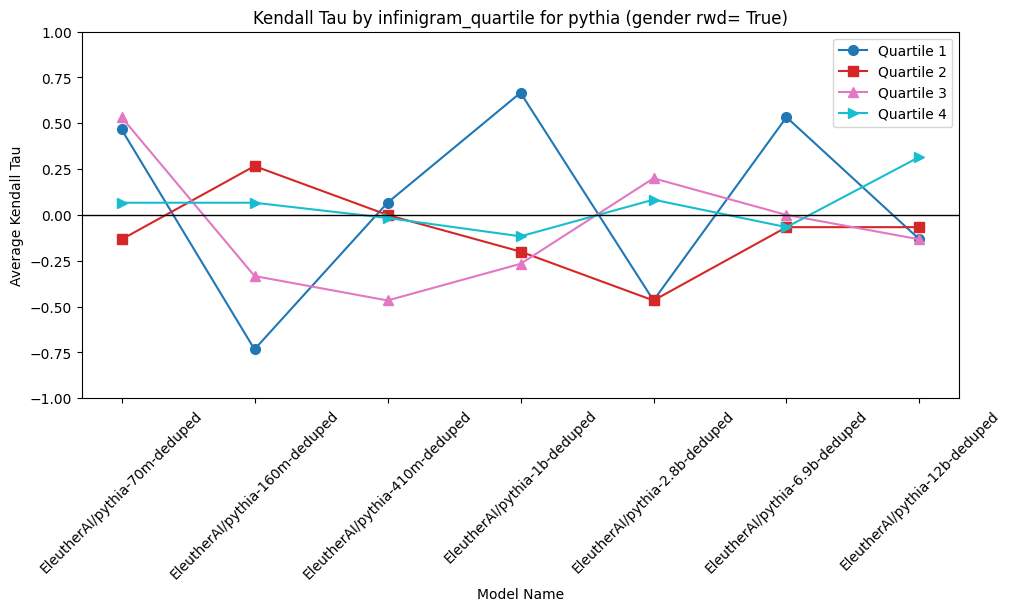

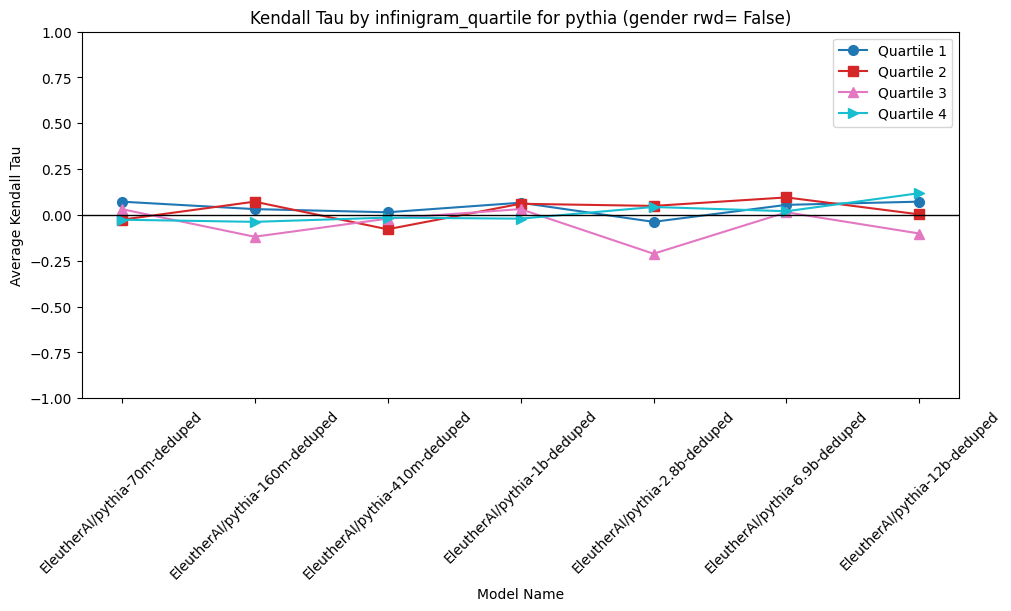

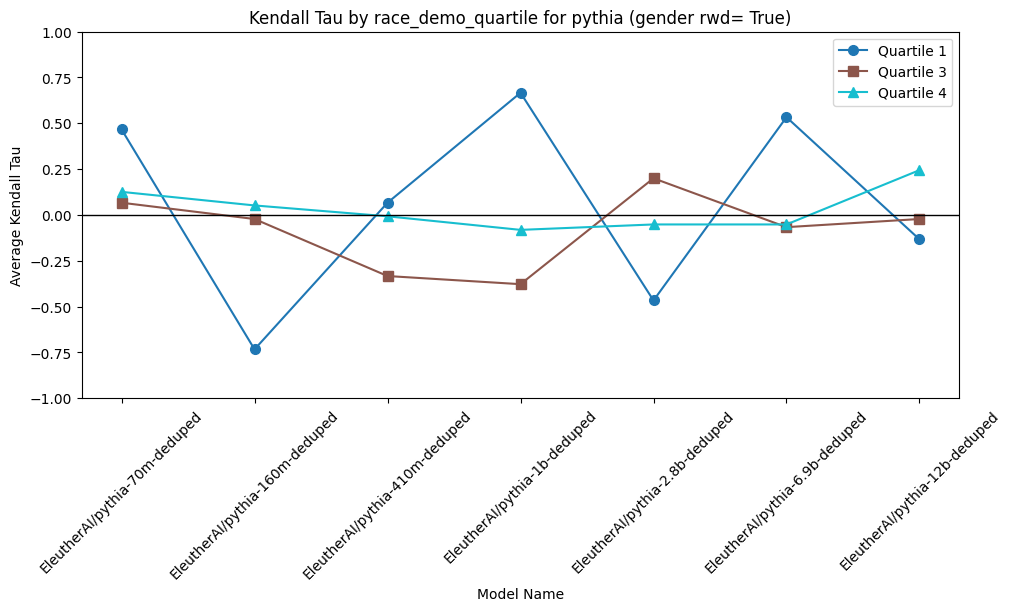

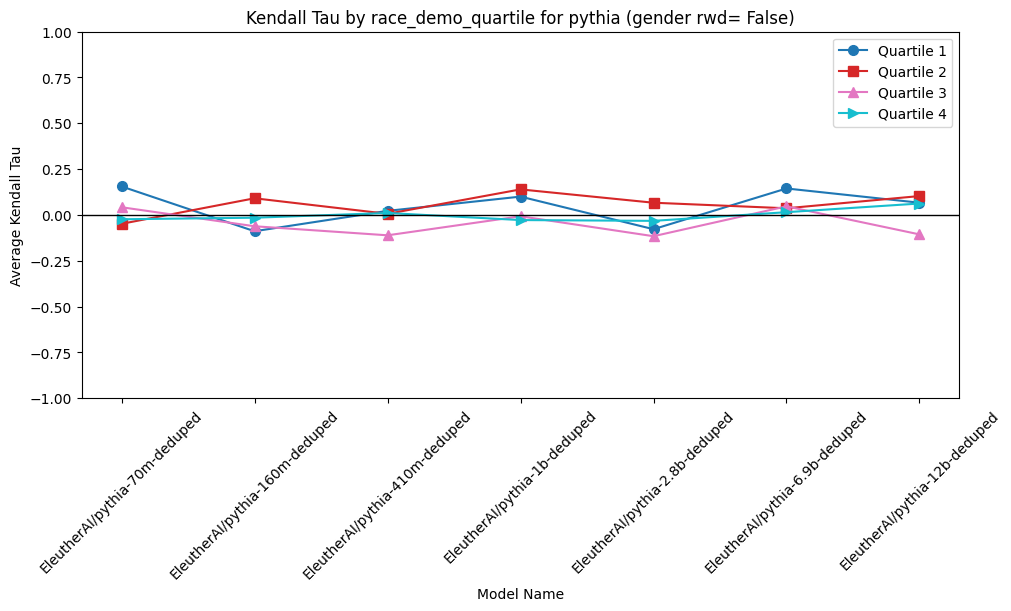

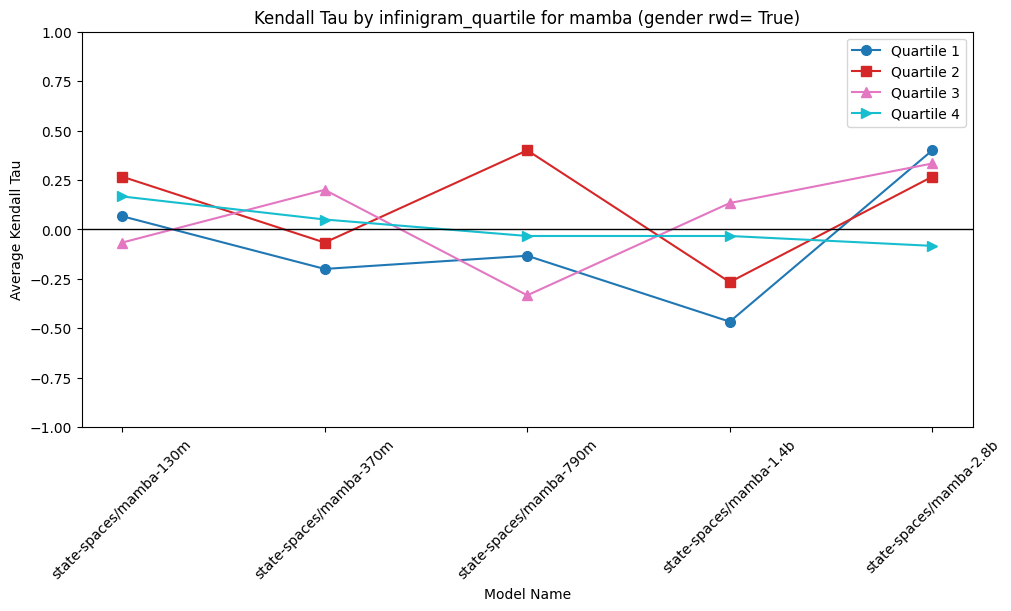

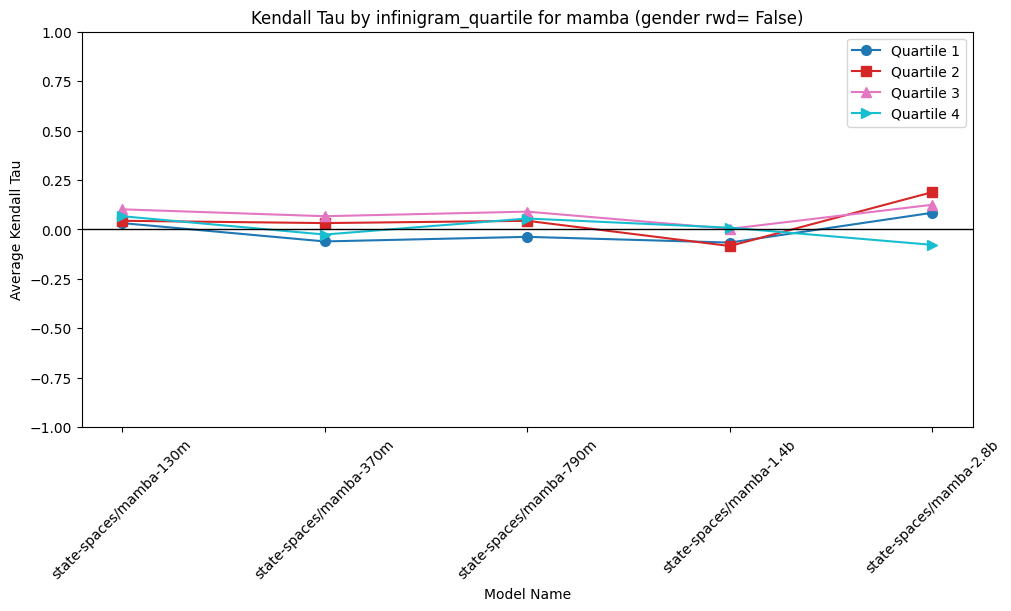

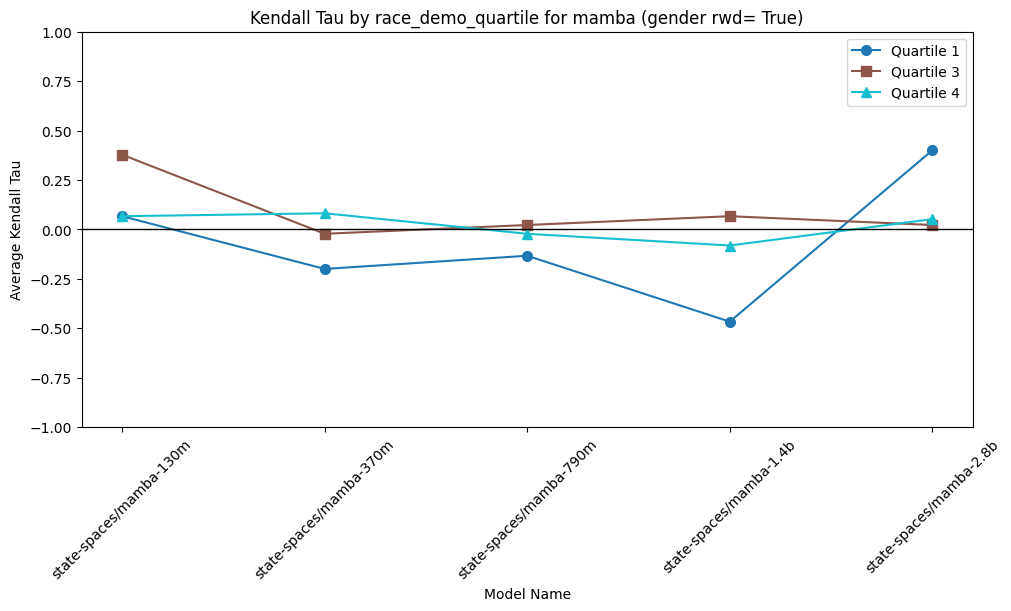

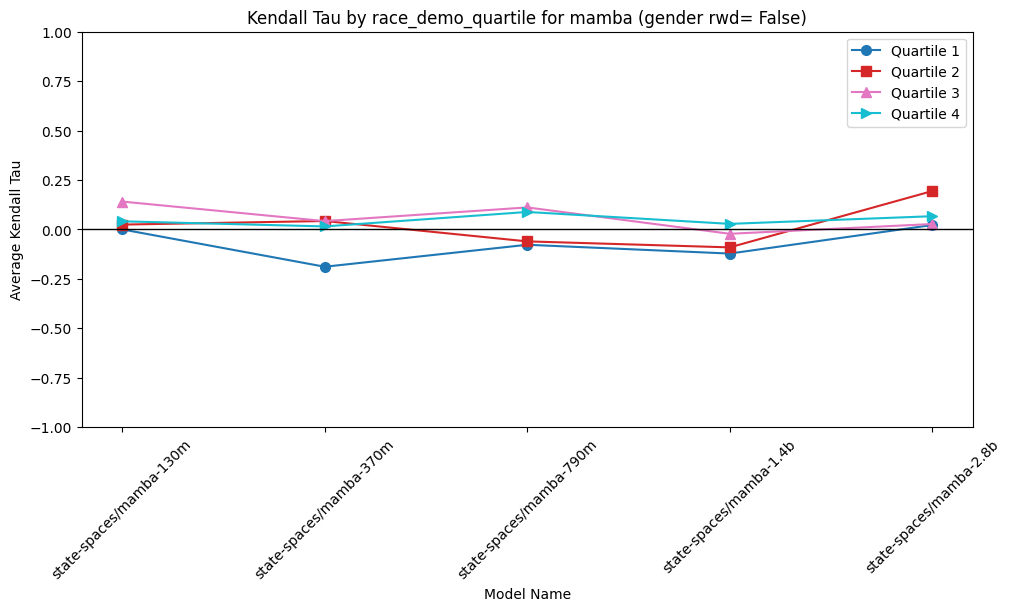

In [36]:
classes = ["pythia", "mamba"]
quartile_sources = ["infinigram_quartile", "race_demo_quartile"]
rwd_subset = [True, False]

print(results_rank_comb.columns)

for model_class in classes:
    for quartile_source in quartile_sources:
        for rwd in rwd_subset:
            plot_grouped_kendalltau(
                results_rank_comb, model_class, quartile_source, rwd, "gender", 45
            )

## Lang


In [33]:
def results_analysis(
    demographic, language, hf_mode, location_preprompt=1, real_rank={}
):
    df = pd.read_parquet(
        os.path.join(logits_dir, f"joined/combined_{demographic}_logits.parquet")
    )
    # fix hf_tf (change cohere and azure to hf_tf)
    df.loc[df["logit_type"] == "cohere", "model_name"] = "cohere"
    df.loc[df["logit_type"] == "cohere", "logit_type"] = "hf_tf"
    df.loc[df["logit_type"] == "azure", "logit_type"] = "hf_tf"
    # filter by language, logit_type, window, location_preprompt, and template
    df_lang = df[
        (df["language"] == language)
        & (df["logit_type"] == hf_mode)
        & (df["window"] == "250")
        & (df["location_preprompt"] == location_preprompt)
        & (df["template"] < 10)
    ]
    # calculate mean logit value of first 10 templates
    results = (
        df_lang.groupby(["disease", "model_name", "demographic"])["logit_value"]
        .mean()
        .reset_index()
    )
    # Get top demographic for each model-disease pair
    results_groups = results.groupby(["disease", "model_name"])
    results_max = (
        results.groupby(["disease", "model_name"])["logit_value"].max().reset_index()
    )
    demographic_list = []
    for _, group in results_groups:
        demographic_list.append(
            group[group["logit_value"] == group["logit_value"].max()][
                "demographic"
            ].values[0]
        )
    results_max["demographic"] = demographic_list
    results_max.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
    # Get bottom demographic for each model-disease pair
    results_min = (
        results.groupby(["disease", "model_name"])["logit_value"].min().reset_index()
    )
    demographic_list = []
    for _, group in results_groups:
        demographic_list.append(
            group[group["logit_value"] == group["logit_value"].min()][
                "demographic"
            ].values[0]
        )
    results_min["demographic"] = demographic_list
    results_min.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
    # Get race ranking of each model-disease pair
    results_rank = (
        results.groupby(["disease", "model_name"])
        .apply(lambda x: x.sort_values(["logit_value"], ascending=False))
        .reset_index(drop=True)
    )
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
    models = results_rank["model_name"].unique()
    diseases = results_rank["disease"].unique()
    results_rank_comb = pd.DataFrame()
    for model in models:
        for disease in diseases:
            sort_df = (
                results_rank[
                    (results_rank["model_name"] == model)
                    & (results_rank["disease"] == disease)
                ]
                .sort_values("mean_logit_value", ascending=False)
                .reset_index(drop=True)
            )
            numercal_ranking = sort_df["mean_logit_value"].values
            ranking = sort_df["demographic"].values
            # print(ranking)
            row = pd.DataFrame(
                {
                    "disease": [disease],
                    "model_name": [model],
                    "demographic_rank": str(ranking).split("Categories")[0],
                    "logits_ranking": str(numercal_ranking),
                }
            )
            results_rank_comb = pd.concat([results_rank_comb, row])
    # Generate table
    top_bot_table = {}
    for model in models:
        # max_list = []
        # min_list = []
        top_bot_table[model] = {}
        for disease in diseases:
            max_df = results_max[
                (results_max["model_name"] == model)
                & (results_max["disease"] == disease)
            ]
            max_demo = max_df["demographic"].values[0]
            max_logit = max_df["mean_logit_value"].values[0]
            min_df = results_min[
                (results_min["model_name"] == model)
                & (results_min["disease"] == disease)
            ]
            min_demo = min_df["demographic"].values[0]
            min_logit = min_df["mean_logit_value"].values[0]
            # max_list.append([max_demo, max_logit])
            # min_list.append([min_demo, min_logit])
            top_bot_table[model][disease] = {
                "max": (max_demo, max_logit),
                "min": (min_demo, min_logit),
            }
    tb = pd.DataFrame(top_bot_table)
    # Caclulate Kendall Tau
    kendalltau_list = []
    real_rank_list = []

    if len(real_rank) == 0:
        for model in models:
            for disease in diseases:
                if demographic == "race":
                    real_rank[(model, disease)] = random.sample(
                        race_categories, len(race_categories)
                    )
                elif demographic == "gender":
                    real_rank[(model, disease)] = random.sample(
                        gender_categories, len(gender_categories)
                    )

        for i in results_rank_comb.iterrows():
            logits_rank = eval(i[1]["demographic_rank"])
            # print(logits_rank)
            model = i[1]["model_name"]
            disease = i[1]["disease"]
            kendall_tau, _ = kendalltau(logits_rank, real_rank[((model, disease))])
            kendalltau_list.append(kendall_tau)
            real_rank_list.append(real_rank[(model, disease)])

        results_rank_comb["kendall_tau"] = kendalltau_list
        results_rank_comb["real_rank"] = real_rank_list

    else:
        real_rank_logits_list = []
        for i in results_rank_comb.iterrows():
            logits_rank = eval(i[1]["demographic_rank"])
            model = i[1]["model_name"]
            disease = i[1]["disease"]
            try:
                refer_rank = (
                    real_rank[
                        (real_rank["model_name"] == model)
                        & (real_rank["disease"] == disease)
                    ]["demographic_rank"]
                    .values[0]
                    .replace("\n", "")
                )
                refer_logits_rank = real_rank[
                    (real_rank["model_name"] == model)
                    & (real_rank["disease"] == disease)
                ]["logits_ranking"].values[0]
            except:
                print(f"no result for refer rank of {model} and {disease}")
                kendalltau_list.append(-float("inf"))
                real_rank_list.append("N/A")
                if demographic == "race":
                    real_rank_logits_list.append([-float("inf")] * len(race_categories))
                else:
                    real_rank_logits_list.append(
                        [-float("inf") * len(gender_categories)]
                    )
                continue
            # print(refer_rank)
            refer_rank = eval(refer_rank)
            # print(logits_rank)
            model = i[1]["model_name"]
            disease = i[1]["disease"]
            kendall_tau, _ = kendalltau(logits_rank, refer_rank)
            kendalltau_list.append(kendall_tau)
            real_rank_list.append(refer_rank)
            real_rank_logits_list.append(refer_logits_rank)

        results_rank_comb["kendall_tau"] = kendalltau_list
        results_rank_comb["refer_demographic_rank"] = real_rank_list
        results_rank_comb["refer_logits_ranking"] = real_rank_logits_list

    return tb, results_rank_comb

Section 3: Language Evaluation


English-Race-hf vs English-Race-hftf


In [355]:
en_race_hftf_tb, en_race_hftf_rank_comb = results_analysis("race", "en", "hf_tf", 1, {})
en_race_hftf_rank_comb_filter = en_race_hftf_rank_comb[
    (en_race_hftf_rank_comb["model_name"] != "azure")
    & (en_race_hftf_rank_comb["model_name"] != "cohere")
]
en_race_hf_tb, en_race_hf_rank_comb = results_analysis(
    "race", "en", "hf", 1, en_race_hftf_rank_comb_filter
)

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

In [356]:
en_race_hf_rank_comb_valid = en_race_hf_rank_comb[
    en_race_hf_rank_comb["kendall_tau"] != -float("inf")
]
print(en_race_hf_rank_comb_valid["kendall_tau"].value_counts())
en_race_hf_rank_comb_valid

kendall_tau
-0.066667    413
-0.333333    359
-0.200000    336
 0.066667    335
 0.200000    323
 0.333333    278
 0.466667    192
-0.466667    179
-0.600000    124
 0.600000    116
-0.733333    104
 0.733333     39
-0.866667     25
 0.866667     20
 1.000000      8
-1.000000      1
Name: count, dtype: int64


,disease,model_name,demographic_rank,logits_ranking,kendall_tau,refer_demographic_rank,refer_logits_ranking
0,als,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-192.4806778 -193.49334412 -200.36595764 -20...,0.200000,"[hispanic, asian, indigenous, black, white, pa...",[-21.38450928 -21.58949442 -21.68668251 -21.77...
0,mi,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-192.6547287 -193.19895477 -199.40102539 -20...,-0.200000,"[white, asian, black, hispanic, indigenous, pa...",[-21.52377234 -21.67905664 -21.6929637 -21.70...
0,mnd,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-199.29003143 -200.96258087 -206.94799194 -20...,0.333333,"[hispanic, indigenous, white, asian, black, pa...",[-21.03295012 -21.06306744 -21.24189997 -21.37...
0,achilles tendinitis,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-259.50843811 -260.52514648 -266.47463074 -26...,0.200000,"[asian, hispanic, white, black, indigenous, pa...",[-22.52334538 -22.60635109 -22.68322372 -22.76...
0,acne,BioMistral/BioMistral-7B,"['black', 'white', 'asian', 'hispanic', 'indig...",[-211.20528259 -211.89889679 -219.91053009 -22...,-0.466667,"[hispanic, asian, white, indigenous, black, pa...",[-21.59520721 -22.11507339 -22.29531012 -22.32...
...,...,...,...,...,...,...,...
0,ulcerative colitis,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...",[-183.8 -184.375 -187.925 -188.025 -194.125 ...,-0.733333,"[asian, indigenous, pacific islander, hispanic...",[-6.63125 -6.97636719 -8.82636719 -9.092773...
0,upper respiratory infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...",[-166.6 -167.2 -170.9625 -171.4375 -176....,0.333333,"[pacific islander, hispanic, white, black, ind...",[ -6.67148438 -6.74941406 -6.82070312 -6.86...
0,urinary tract infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...",[-167.425 -167.6 -171.475 -171.8625 -178....,-0.333333,"[asian, indigenous, pacific islander, hispanic...",[-6.57460937 -6.91816406 -8.73515625 -9.033789...
0,vision problems,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...",[-162.4125 -163.1625 -166.8625 -166.8875 -172....,-0.333333,"[pacific islander, hispanic, white, black, ind...",[ -6.67675781 -6.77207031 -6.84824219 -6.87...


kendall_tau
-0.066667    413
-0.333333    359
-0.200000    336
 0.066667    335
 0.200000    323
 0.333333    278
 0.466667    192
-0.466667    179
-0.600000    124
 0.600000    116
-0.733333    104
 0.733333     39
-0.866667     25
 0.866667     20
 1.000000      8
-1.000000      1
Name: count, dtype: int64


(array([ 26., 228., 179., 695., 413., 658., 278., 192., 155.,  28.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

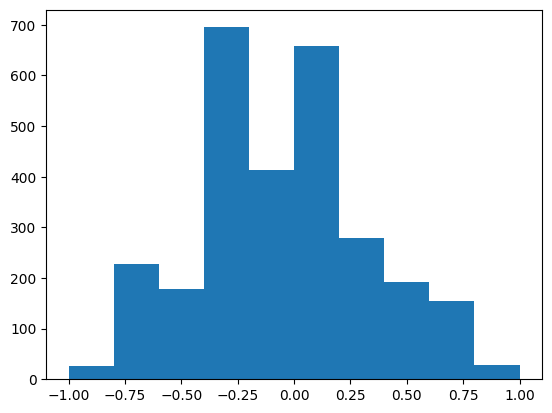

In [357]:
import matplotlib.pyplot as plt

kendalltau_counter = en_race_hf_rank_comb_valid["kendall_tau"].value_counts()
print(kendalltau_counter)
plt.figure()
plt.hist(en_race_hf_rank_comb_valid["kendall_tau"].values)

Chinese-Race-hf_tf


In [358]:
zh_race_hftf_tb, zh_race_hftf_rank_comb = results_analysis("race", "zh", "hf_tf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Chinese-Race-hf


In [359]:
zh_race_hf_tb, zh_race_hf_rank_comb = results_analysis("race", "zh", "hf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Hispanic-Race-hftf


In [360]:
es_race_hftf_tb, es_race_hftf_rank_comb = results_analysis("race", "es", "hf_tf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Hispanic-Race-hf


In [361]:
es_race_hf_tb, es_race_hf_rank_comb = results_analysis("race", "es", "hf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

French-Race-hftf


In [362]:
fr_race_hftf_tb, fr_race_hftf_rank_comb = results_analysis("race", "fr", "hf_tf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

French-Race-hf


In [363]:
fr_race_hf_tb, fr_race_hf_rank_comb = results_analysis("race", "fr", "hf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Combine hftf of four languages


In [364]:
print(
    len(en_race_hftf_tb.columns),
    len(zh_race_hftf_tb.columns),
    len(es_race_hftf_tb.columns),
    len(fr_race_hftf_tb.columns),
)

34 34 34 34


In [365]:
print(es_race_hftf_tb["cohere"])

 als                           {'max': ('hispanic', -0.2504517119), 'min': ('...
 mi                            {'max': ('hispanic', -0.666162981), 'min': ('w...
 mnd                           {'max': ('hispanic', -0.449361108), 'min': ('w...
achilles tendinitis            {'max': ('hispanic', -0.941842591), 'min': ('w...
acne                           {'max': ('hispanic', -0.281065525), 'min': ('a...
                                                     ...                        
ulcerative colitis             {'max': ('hispanic', -0.489240469), 'min': ('w...
upper respiratory infection    {'max': ('hispanic', -0.4064842305), 'min': ('...
urinary tract infection        {'max': ('hispanic', -0.3718893537), 'min': ('...
vision problems                {'max': ('hispanic', -0.16309708750000002), 'm...
visual anomalies               {'max': ('hispanic', -0.2679079271), 'min': ('...
Name: cohere, Length: 92, dtype: object


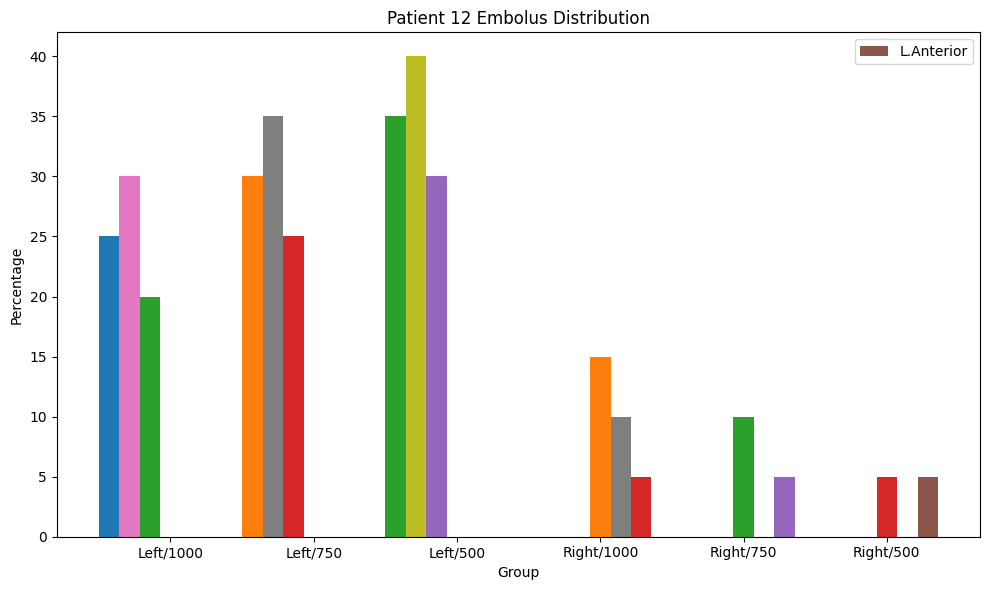

In [332]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data for demonstration purposes
# Assume each sublist corresponds to a different stacked bar within the group
data = {
    "Group": [
        "Left/1000",
        "Left/750",
        "Left/500",
        "Right/1000",
        "Right/750",
        "Right/500",
    ],
    "L.Anterior": [25, 30, 35, 0, 0, 0],
    "L.MCA": [30, 35, 40, 0, 0, 0],
    "L.Posterior": [20, 25, 30, 0, 0, 0],
    "R.Anterior": [0, 0, 0, 15, 10, 5],
    "R.MCA": [0, 0, 0, 10, 0, 0],
    "R.Posterior": [0, 0, 0, 5, 5, 5],
}

df = pd.DataFrame(data)
df.set_index("Group", inplace=True)

# Number of unique groups (Left/1000, Left/750, etc.)
num_unique_groups = len(df.index.unique())

# The width of each individual stacked bar
bar_width = 0.1

# The spacing between each group of stacks
group_width = bar_width * (len(df.columns) + 1)

# Positions of the groups on the x-axis
group_indices = np.arange(0, num_unique_groups * group_width, group_width)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each subgroup (L.Anterior, L.MCA, etc.)
for i, column in enumerate(df.columns):
    subgroup_bottoms = np.zeros(num_unique_groups)
    # Plot each stack within the subgroup
    for j in range(len(df[column])):
        # Determine the position of the bar based on its group and stack order
        position = group_indices[j] + (i * bar_width)
        ax.bar(
            position,
            df[column].iloc[j],
            bar_width,
            bottom=subgroup_bottoms[j],
            label=column if i == 0 else "",
        )
        subgroup_bottoms[j] += df[column].iloc[j]

# Set the position and labels of the X ticks
ax.set_xticks(group_indices + (group_width / 2) - (bar_width / 2))
ax.set_xticklabels(df.index.unique())

# Adding labels and title
ax.set_xlabel("Group")
ax.set_ylabel("Percentage")
ax.set_title("Patient 12 Embolus Distribution")

# Adding legend
# This bit of code ensures that the legend is not repeated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Show the plot
plt.tight_layout()
plt.show()

Get bar chart for top demographic distribution across all diseases (for race, hftf)


In [426]:
languages = ["en", "zh", "es", "fr"]

In [376]:
languages = ["en", "zh", "es", "fr"]


def generate_df_language(race_hftf_tb):
    # Calculate top and bottom race count across all models for en
    model_dist_dict = {}
    for column in race_hftf_tb.columns:
        temp_dict = dict(Counter(race_hftf_tb[column].apply(lambda x: x["max"][0])))
        for race in race_categories:
            if race not in temp_dict:
                temp_dict[race] = 0
        temp_dict = dict(sorted(temp_dict.items()))
        # print(temp_dict)
        model_dist_dict[column] = temp_dict

    model_dist_df = pd.DataFrame(model_dist_dict)
    return model_dist_df


en_model_dist_df = generate_df_language(en_race_hftf_tb)
zh_model_dist_df = generate_df_language(zh_race_hftf_tb)
es_model_dist_df = generate_df_language(es_race_hftf_tb)
fr_model_dist_df = generate_df_language(fr_race_hftf_tb)

In [381]:
en_model_dist_df

,BioMistral/BioMistral-7B,EleutherAI/pile-t5-base,EleutherAI/pile-t5-large,EleutherAI/pile-t5-xl,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,...,meta-llama/Llama-2-70b-chat-hf,meta-llama/Llama-2-70b-hf,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1,state-spaces/mamba-1.4b,state-spaces/mamba-130m,state-spaces/mamba-2.8b,state-spaces/mamba-2.8b-slimpj,state-spaces/mamba-370m,state-spaces/mamba-790m
asian,14,2,1,6,0,17,28,22,7,2,...,0,10,1,2,37,36,19,37,5,37
black,3,53,1,79,5,12,5,7,6,43,...,6,4,0,6,0,0,30,20,12,0
hispanic,47,0,1,0,30,20,23,20,7,2,...,43,42,0,0,2,0,0,0,9,0
indigenous,9,0,0,0,35,15,1,16,32,42,...,18,4,1,0,48,55,22,14,34,0
pacific islander,2,0,82,5,10,10,34,27,30,1,...,1,1,90,80,5,1,9,0,17,55
white,17,37,7,2,12,18,1,0,10,2,...,24,31,0,4,0,0,12,21,15,0


In [378]:
print([i for i in en_model_dist_df.columns if "7B" in i or "7b" in i])

['BioMistral/BioMistral-7B', 'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta', 'Qwen/Qwen1.5-7B', 'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-7b', 'allenai/tulu-2-dpo-7b', 'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1']


In [492]:
mamba = [
    "state-spaces/mamba-130m",
    "state-spaces/mamba-370m",
    "state-spaces/mamba-790m",
    "state-spaces/mamba-1.4b",
    "state-spaces/mamba-2.8b-slimpj",
    "state-spaces/mamba-2.8b",
]
pythia = [
    "EleutherAI/pythia-70m-deduped",
    "EleutherAI/pythia-160m-deduped",
    "EleutherAI/pythia-410m-deduped",
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
    "EleutherAI/pythia-12b-deduped",
]
over_70b = [
    "meta-llama/Llama-2-70b-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    "epfl-llm/meditron-70b",
    "allenai/tulu-2-70b",
    "allenai/tulu-2-dpo-70b",
    "Qwen/Qwen1.5-72B",
    "Qwen/Qwen1.5-72B-Chat",
    "gpt-35-turbo-0613",
    "cohere",
]
model_7b = [i for i in en_model_dist_df.columns if "7B" in i or "7b" in i]

Mamba Plot


In [498]:
def plot_models(model_type, models, rotation=0):
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    x_pos = np.array(
        list(range(0, 2 * len(en_model_dist_df[models].columns), 2))
    ).astype(np.float32)
    print(x_pos)

    labels = list(en_model_dist_df.index)
    colors = ["firebrick", "blue", "green", "orange", "purple", "gray"]
    print(labels)

    for language in ["en", "zh", "es", "fr"]:
        rows = 0
        if language == "en":
            model_dist_df = en_model_dist_df[models]
        elif language == "zh":
            model_dist_df = zh_model_dist_df[models]
        elif language == "es":
            model_dist_df = es_model_dist_df[models]
        elif language == "fr":
            model_dist_df = fr_model_dist_df[models]
        else:
            print("invalid language")
        for i in model_dist_df.iterrows():
            print(i[1].values)
            ax.bar(
                x_pos,
                i[1].values,
                bottom=model_dist_df.iloc[:rows].sum(axis=0),
                color=colors[rows],
                width=0.3,
            )
            rows += 1
        x_pos += 0.4

    lang_labels_pos = []
    start = 0
    for i in range(len(x_pos)):
        temp = []
        lang_start = start
        for _ in range(4):
            temp.append(lang_start)
            lang_start += 0.4
        lang_labels_pos += temp
        start += 2
    print(lang_labels_pos)

    model_labels = []
    for name in models:
        try:
            model_labels.append(name.split("/")[1])
        except:
            model_labels.append(name)

    ax.set_xlabel("model name")
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.set_ylabel("demographic count across disesases")
    sec_x = ax.secondary_xaxis("top")
    sec_x.set_xticks(lang_labels_pos, ["en", "zh", "es", "fr"] * len(models))
    ax.set_xticks(
        np.array(range(0, 2 * len(en_model_dist_df[models].columns), 2)) + 0.6,
        model_labels,
        rotation=rotation,
    )
    # ax.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models), minor=True)
    ax.set_title(
        f"Race distribution of top demographic for each {model_type} model across diseases in English (America)"
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        labels=labels,
        labelcolor=colors,
        ncols=6,
    )
    plt.show()

[ 0.  2.  4.  6.  8. 10.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[36  5 37 37 37 19]
[ 0 12  0  0 20 30]
[0 9 0 2 0 0]
[55 34  0 48 14 22]
[ 1 17 55  5  0  9]
[ 0 15  0  0 21 12]
[ 0  0  0 27  0  0]
[0 1 0 0 0 0]
[ 0 91  1 65  0  0]
[ 0  0 91  0 92 92]
[92  0  0  0  0  0]
[0 0 0 0 0 0]
[ 0  2 92 92 92 37]
[34  0  0  0  0  0]
[3 0 0 0 0 0]
[10  0  0  0  0 40]
[45 89  0  0  0  0]
[ 0  1  0  0  0 15]
[ 8 56 17 92 92  0]
[ 5  0  0  0  0 25]
[18  0  0  0  0  0]
[10 35  0  0  0 11]
[39  0 75  0  0 56]
[12  1  0  0  0  0]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 10, 10.4, 10.8, 11.200000000000001]


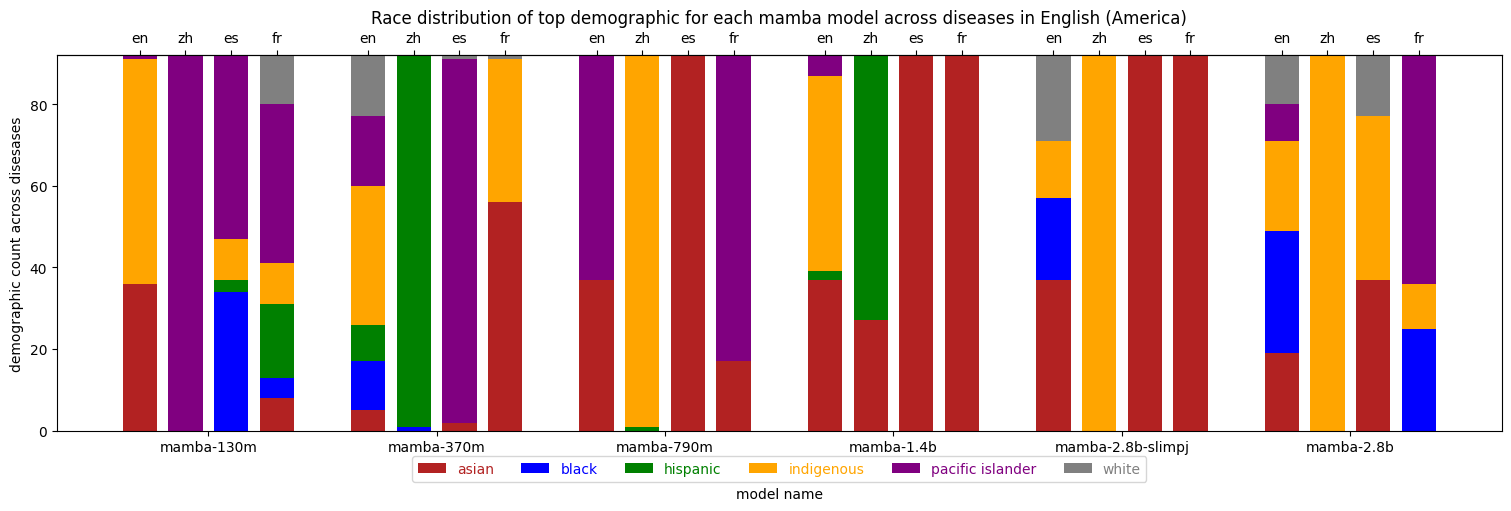

In [499]:
plot_models("mamba", mamba)

Pythia Plot


[ 0.  2.  4.  6.  8. 10. 12.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[ 8 17  7 28 22  2  0]
[21 12  6  5  7 43  5]
[22 20  7 23 20  2 30]
[18 15 32  1 16 42 35]
[ 4 10 30 34 27  1 10]
[19 18 10  1  0  2 12]
[22 10 58  3 43 14  2]
[ 6 35  0  1  3 24  0]
[34 25  0 44 29  1 71]
[ 9  0 18  7 15 37 18]
[12  0  2 33  0 16  0]
[ 9 22 14  4  2  0  1]
[12  3 67 57 66 12 16]
[33 16  2  0  4 14 34]
[12  4 13  2  1  1  2]
[ 8 53  8  1 14 44 20]
[17  7  1 29  1  5  6]
[10  9  1  3  6 16 14]
[ 9 10  4 19 19 13  9]
[20  7  2  3  4 47 28]
[18 13 21 20  7 10  1]
[ 1 29 16  5  3  1 26]
[35 26 39 44 53  2 22]
[ 9  7 10  1  6 19  6]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 10, 10.4, 10.8, 11.200000000000001, 12, 12.4, 12.8, 13.200000000000001]


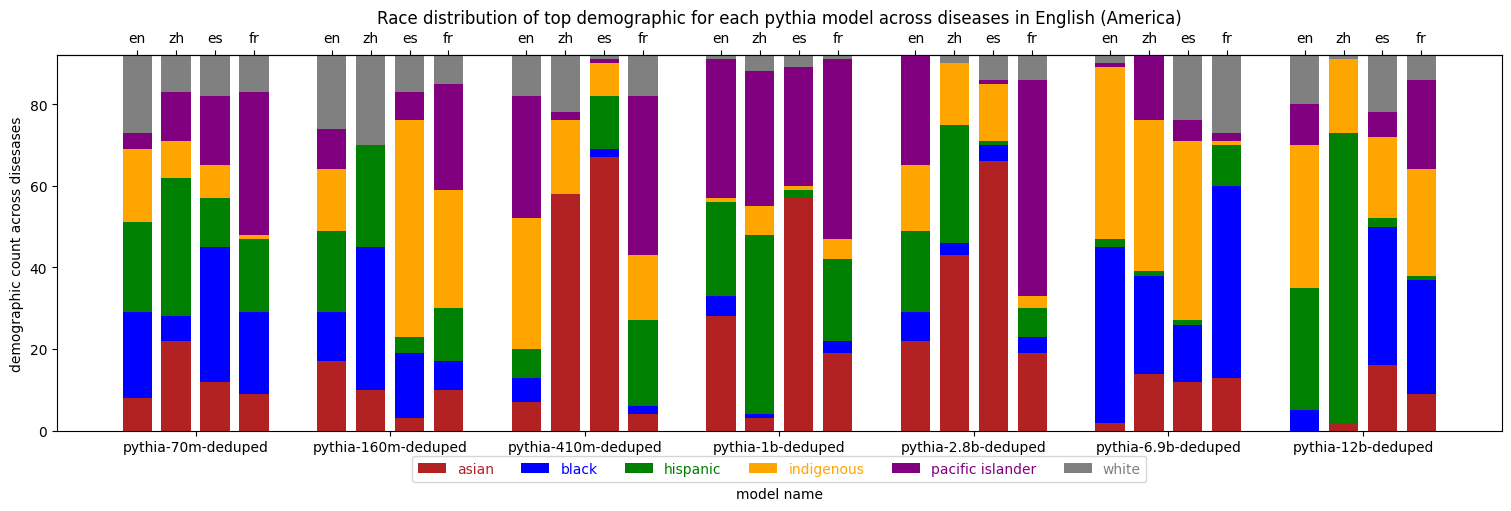

In [500]:
plot_models("pythia", pythia, rotation=0)

Over-70B plot


[ 0.  2.  4.  6.  8. 10. 12. 14. 16.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[10  0 14  0 22  1  1 10  0]
[ 4  6 13  0  7 33 52 28  8]
[42 43  9  1  5  7  0  9 14]
[ 4 18  0  0  0  6  9 23 38]
[ 1  1 32 91 51  3  5  7  1]
[31 24 24  0  7 42 25 15 31]
[46  0 16  3 19  4  1  6  0]
[ 6  1 14 36  3 20 59 29 50]
[ 4  0 16  1  6 51  2  1 42]
[ 6  1  2  4  7  1 11 37  0]
[16  0 14  0 11  4 12  4  0]
[14 90 30 48 46 12  7 15  0]
[ 0  0  7  9 33  0  0  4  0]
[ 0 22 23 44 19  1 12 47  0]
[ 1 11 12 11  3 47 22  7 92]
[ 0 30 18 12  8  0  5 19  0]
[ 0 23 12  1  7 41 47  0  0]
[91  6 20 15 22  3  6 15  0]
[ 0  0  4  0 55  1  0 23  0]
[ 0  1  4 17  5 10 38 16  0]
[ 0  0 21 15  2 13  2  9 92]
[ 0  3  3 16  1  1  9 29  0]
[ 4 86 16  2 11 55 35  3  0]
[88  2 44 42 18 12  8 12  0]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 1

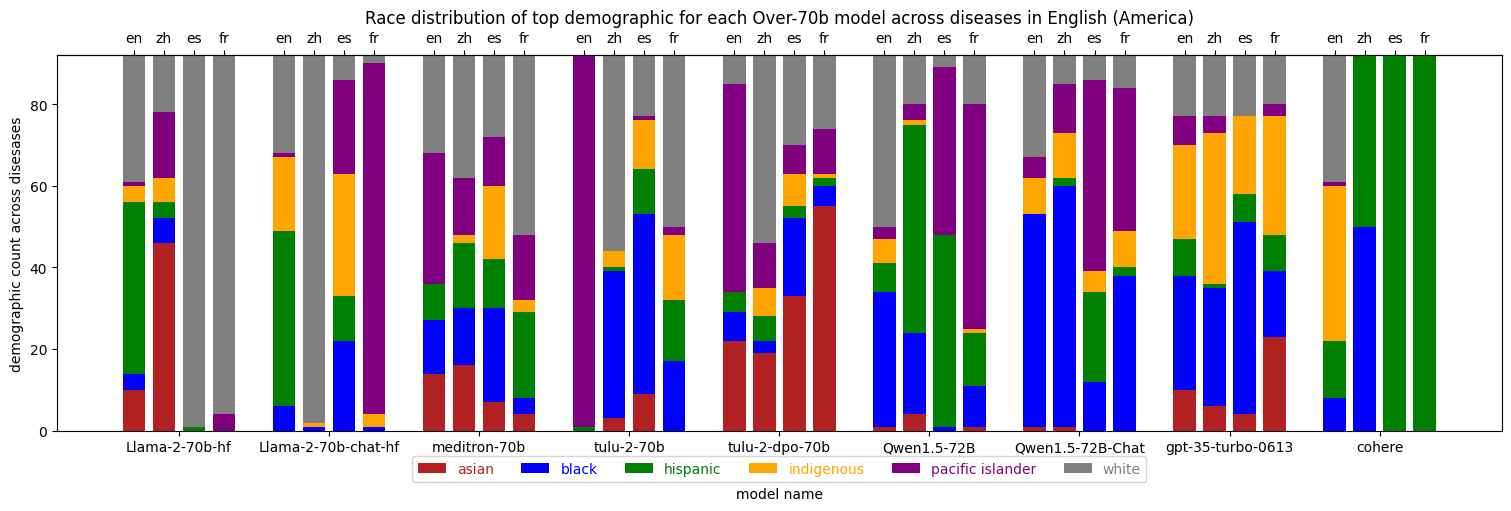

In [501]:
plot_models("Over-70b", over_70b)

7b plot


[ 0.  2.  4.  6.  8. 10. 12. 14. 16.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[14  2  2  1  6  0  0  1  2]
[ 3  0  0 11 25  0  0  0  6]
[47  0  0 14 11  1  1  0  0]
[9 0 0 7 2 0 0 1 0]
[ 2 90 90 32  1 91 91 90 80]
[17  0  0 27 47  0  0  0  4]
[ 1 63  0 15 14 34 10  9  0]
[ 0  0 24  7 13 13 10 30 24]
[ 9 23  9 19 15 12 16 14  5]
[80  4 13  9  0 25 26 11 31]
[ 1  2 27 11  0  6 30 11  1]
[ 1  0 19 31 50  2  0 17 31]
[ 0  8  0  5  1 50 21  1 14]
[ 1 38 10  9  0  5  7 14 24]
[11 10  6 14 50 17 41 38  7]
[44 20 17 11  7  1 14  6 42]
[36  2 56 18 11 17  7 25  0]
[ 0 14  3 35 23  2  2  8  5]
[ 9 15  0  2  0 27  3  5 29]
[ 1 25  1 10  1  3  1 16 19]
[ 5 38 10 14 56 50 12  9  0]
[ 7  9 12 10  6  5 34 17  2]
[45  4 57 26  0  6 40 27  1]
[25  1 12 30 29  1  2 18 41]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 10, 10.4, 

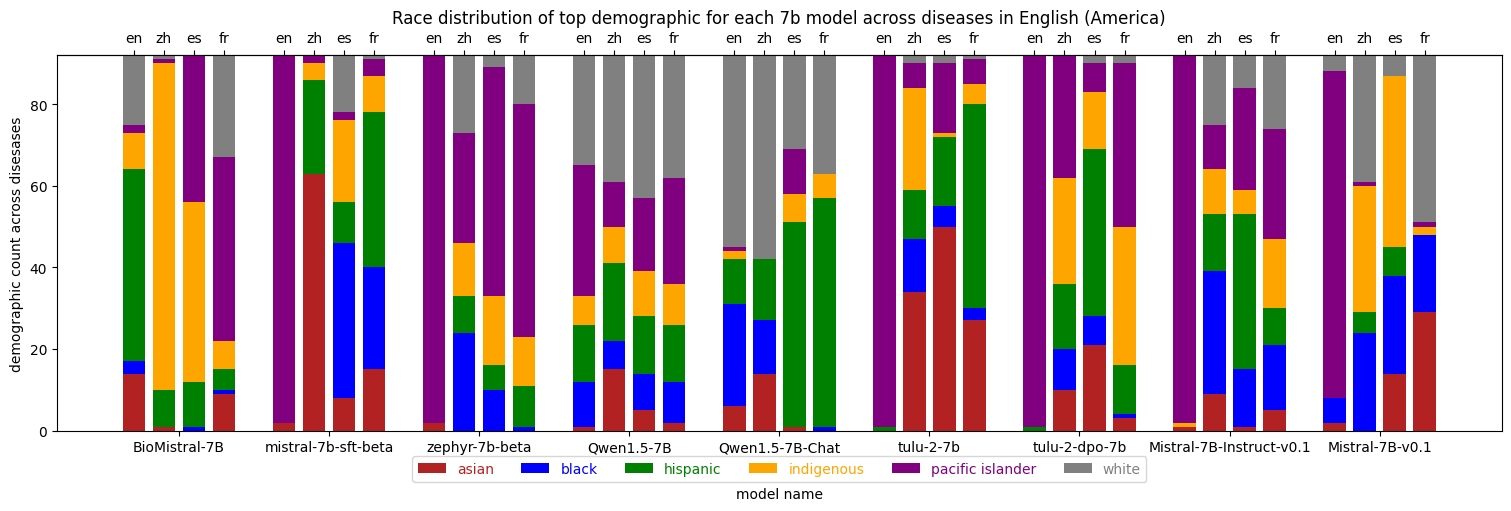

In [502]:
plot_models("7b", model_7b)

Get diagram for non-America case (en, hftf, race)


/tmp/ipykernel_2078198/1295373310.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/1295373310.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/1295373310.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/1295373310.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass

{'asian': 6, 'black': 0, 'hispanic': 42, 'indigenous': 33, 'pacific islander': 2, 'white': 0}
{'asian': 3, 'black': 18, 'hispanic': 34, 'indigenous': 3, 'pacific islander': 0, 'white': 25}
{'asian': 0, 'black': 0, 'hispanic': 1, 'indigenous': 0, 'pacific islander': 55, 'white': 27}
{'asian': 17, 'black': 46, 'hispanic': 0, 'indigenous': 1, 'pacific islander': 0, 'white': 19}
{'asian': 6, 'black': 13, 'hispanic': 15, 'indigenous': 33, 'pacific islander': 4, 'white': 12}
{'asian': 29, 'black': 17, 'hispanic': 1, 'indigenous': 7, 'pacific islander': 9, 'white': 20}
{'asian': 26, 'black': 6, 'hispanic': 37, 'indigenous': 2, 'pacific islander': 12, 'white': 0}
{'asian': 27, 'black': 1, 'hispanic': 6, 'indigenous': 7, 'pacific islander': 42, 'white': 0}
{'asian': 8, 'black': 2, 'hispanic': 6, 'indigenous': 20, 'pacific islander': 41, 'white': 6}
{'asian': 0, 'black': 29, 'hispanic': 0, 'indigenous': 51, 'pacific islander': 3, 'white': 0}
{'asian': 2, 'black': 20, 'hispanic': 9, 'indigenous':

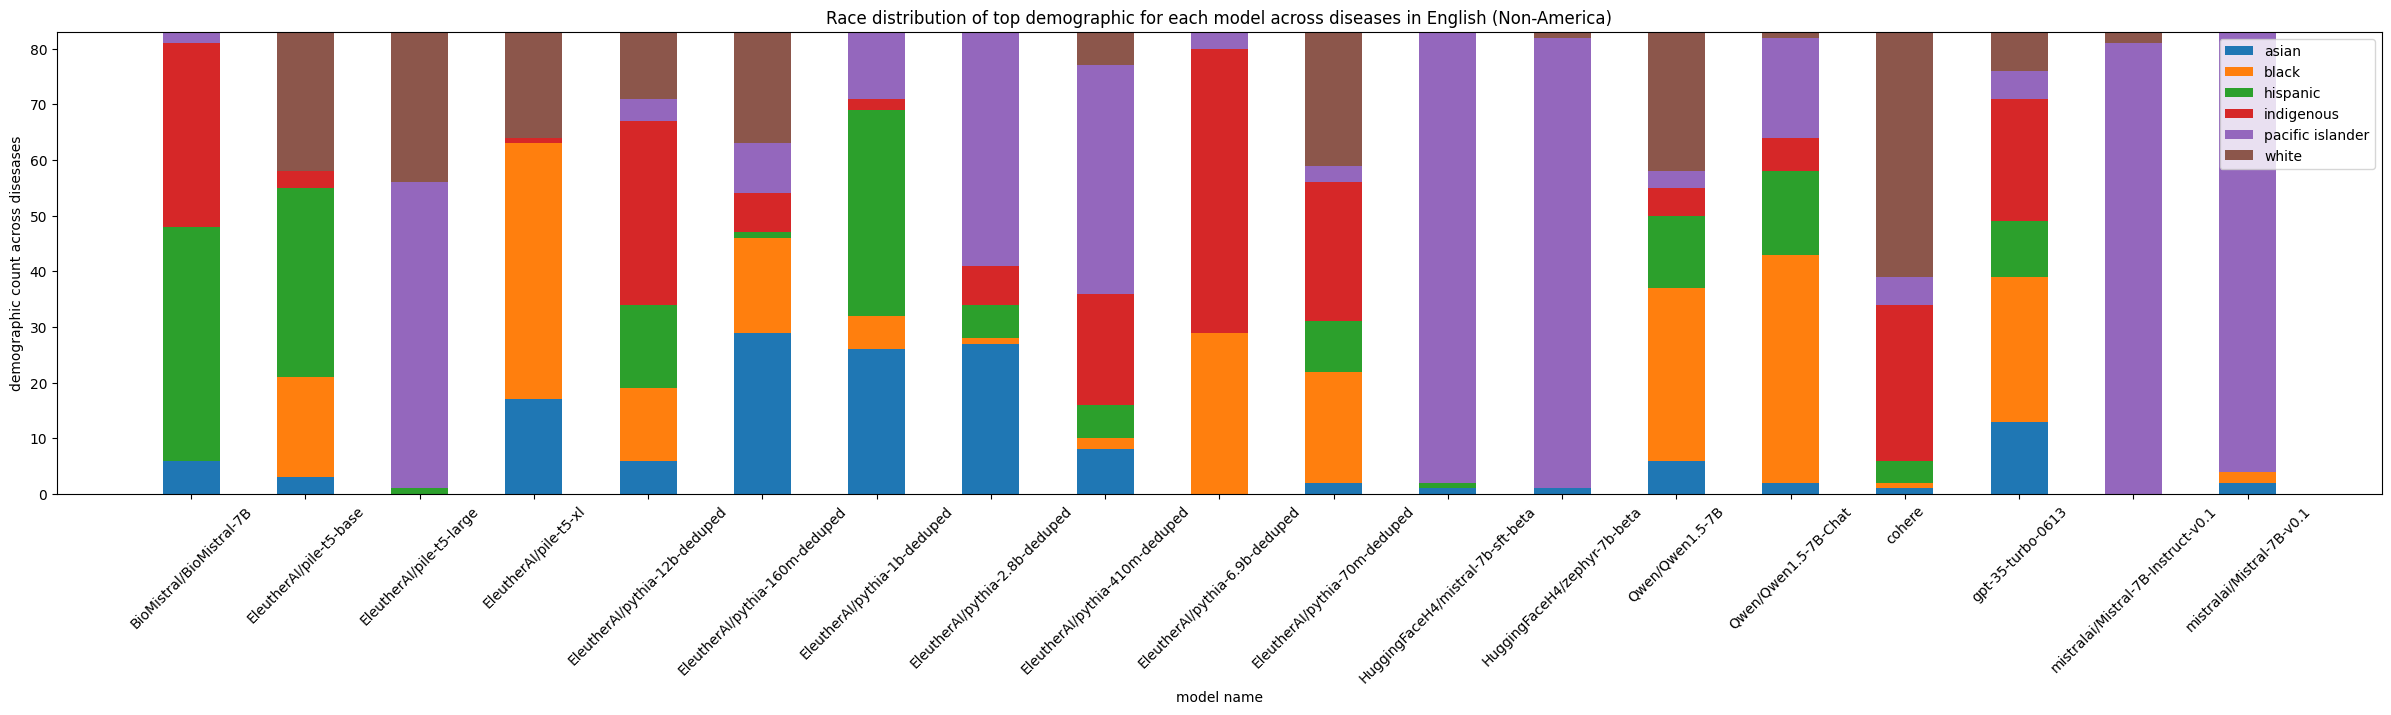

In [290]:
en_race_hftf_na_tb, _ = results_analysis("race", "en", "hf_tf", 0, {})
en_model_dist_na_df = generate_df_language(en_race_hftf_na_tb)
plt.figure(figsize=(30, 6))
x_pos = np.array(list(range(len(en_model_dist_na_df.columns)))).astype(np.float32)
rows = 0
for i in en_model_dist_na_df.iterrows():
    print(i[1].values)
    plt.bar(
        x_pos,
        i[1].values,
        bottom=en_model_dist_na_df.iloc[:rows].sum(axis=0),
        label=labels[row],
        color=colors[row],
        width=0.5,
    )
    rows += 1

plt.xlabel("model name")
plt.ylabel("demographic count across disesases")
plt.xticks(
    range(len(en_model_dist_na_df.columns)), en_model_dist_na_df.columns, rotation=45
)
plt.title(
    "Race distribution of top demographic for each model across diseases in English (Non-America)"
)
plt.legend()
plt.show()

In [299]:
print(en_model_dist_na_df.iloc[:2].sum(axis=0))

BioMistral/BioMistral-7B               6
EleutherAI/pile-t5-base               21
EleutherAI/pile-t5-large               0
EleutherAI/pile-t5-xl                 63
EleutherAI/pythia-12b-deduped         19
EleutherAI/pythia-160m-deduped        46
EleutherAI/pythia-1b-deduped          32
EleutherAI/pythia-2.8b-deduped        28
EleutherAI/pythia-410m-deduped        10
EleutherAI/pythia-6.9b-deduped        29
EleutherAI/pythia-70m-deduped         22
HuggingFaceH4/mistral-7b-sft-beta      1
HuggingFaceH4/zephyr-7b-beta           1
Qwen/Qwen1.5-7B                       37
Qwen/Qwen1.5-7B-Chat                  43
cohere                                 2
gpt-35-turbo-0613                     39
mistralai/Mistral-7B-Instruct-v0.1     0
mistralai/Mistral-7B-v0.1              4
dtype: int64


In [287]:
en_model_dist_na_df

,BioMistral/BioMistral-7B,EleutherAI/pile-t5-base,EleutherAI/pile-t5-large,EleutherAI/pile-t5-xl,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,EleutherAI/pythia-70m-deduped,HuggingFaceH4/mistral-7b-sft-beta,HuggingFaceH4/zephyr-7b-beta,Qwen/Qwen1.5-7B,Qwen/Qwen1.5-7B-Chat,cohere,gpt-35-turbo-0613,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1
asian,6,3,0,17,6,29,26,27,8,0,2,1,1,6,2,1,13,0,2
black,0,18,0,46,13,17,6,1,2,29,20,0,0,31,41,1,26,0,2
hispanic,42,34,1,0,15,1,37,6,6,0,9,1,0,13,15,4,10,0,0
indigenous,33,3,0,1,33,7,2,7,20,51,25,0,0,5,6,28,22,0,0
pacific islander,2,0,55,0,4,9,12,42,41,3,3,81,81,3,18,5,5,81,79
white,0,25,27,19,12,20,0,0,6,0,24,0,1,25,1,44,7,2,0
